In [530]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
plt.style.use('classic')
from IPython.core.display import Image, display
import matplotlib.ticker as ticker
#from shapely.geometry import LineString
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy.spatial.distance import cdist, pdist

Populating the interactive namespace from numpy and matplotlib


# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


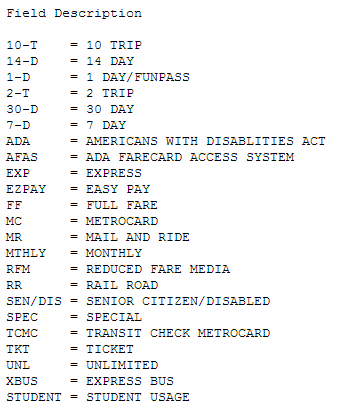

In [126]:
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [4]:
mtaRides = np.load('MTA_Fare.npy')

In [5]:
#after reading the datacube you should see:
mtaRides.shape


(600L, 23L, 194L)

ride types list

In [8]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [9]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [13]:
pd.date_range(start='05/21/2010',end='02/21/2014',freq='W-FRI')[:-1]

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-12-13', '2013-12-20', '2013-12-27', '2014-01-03',
               '2014-01-10', '2014-01-17', '2014-01-24', '2014-01-31',
               '2014-02-07', '2014-02-14'],
              dtype='datetime64[ns]', length=196, freq='W-FRI')

In [17]:
mtaRides = mtaRides.astype('float')
mtaRides[mtaRides==-1] = np.nan

In [67]:
mtaRidesPerWeek = pd.DataFrame(np.nansum(np.nansum(mtaRides,axis=0),axis=0),
                               columns=['mtaRides'])

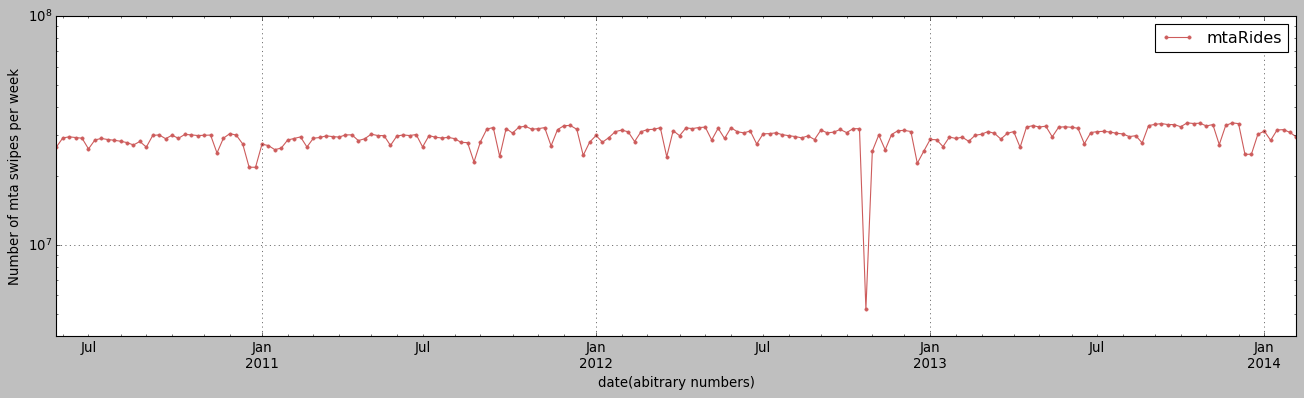

In [135]:
mtaRidesPerWeek.plot(logy=True,color='IndianRed',style='.-',figsize=(20,5))
plt.xlabel('date(abitrary numbers)')
plt.ylabel('Number of mta swipes per week')
plt.ylim(4e6,plt.ylim()[1])
plt.grid()
plt.legend()
plt.show()

### Figure 1. the distribution of mtaRides per week for the 194 weeks. We can find that there is a prominent event so a 3-sigma threshold could be set.

In [85]:
mean = mtaRidesPerWeek['mtaRides'].mean()
std = mtaRidesPerWeek['mtaRides'].std()
print ("mean swipes by week {}".format(mean))
print ("stdev swipes by week {}".format(std))
thresholds = [mean + 3 * std, 
              mean - 3 * std]
print ("3-sigma thresholds {} {}".format(*thresholds))
print ("earliest datapoint", min(mtaRidesPerWeek.index), "-", 
       mtaRidesPerWeek.iloc[mtaRidesPerWeek.index == min(mtaRidesPerWeek.index)].\
       mtaRides.values[0], "swipes")

mean swipes by week 29781349.8711
stdev swipes by week 2991680.90141
3-sigma thresholds 38756392.5754 20806307.1669
earliest datapoint 0 - 26720267.0 swipes


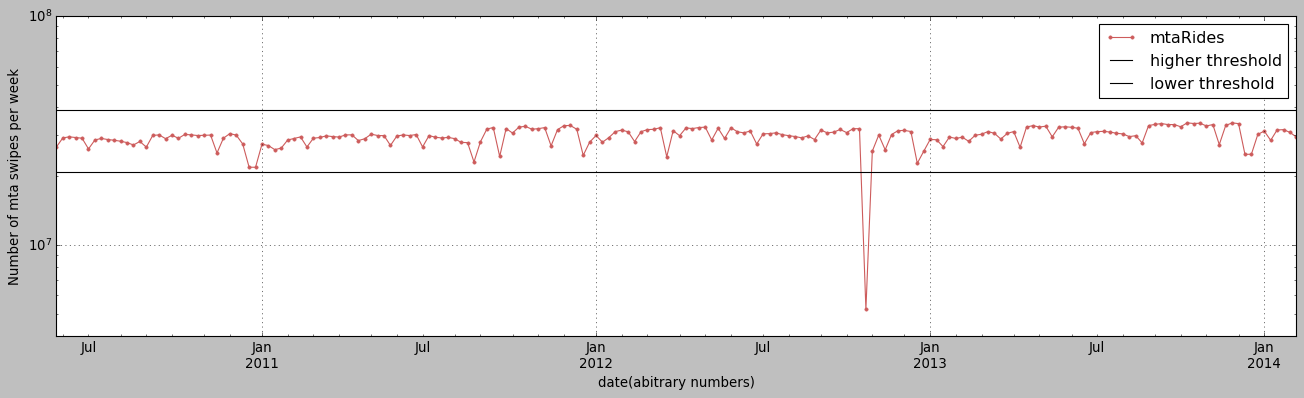

In [134]:
mtaRidesPerWeek.plot(logy=True,color='IndianRed',style='.-',figsize=(20,5))
plt.plot([plt.xlim()[0],plt.xlim()[1]],[thresholds[0],thresholds[0]],color='k',
        label='higher threshold')
plt.plot([plt.xlim()[0],plt.xlim()[1]],[thresholds[1],thresholds[1]],color='k',
        label='lower threshold')
plt.xlabel('date(abitrary numbers)')
plt.ylabel('Number of mta swipes per week')
plt.ylim(4e6,plt.ylim()[1])
plt.grid()
plt.legend()
plt.show()

### Figure 2. the distribution of mtaRides per week for the 194 weeks with thresholds.

In [104]:
mtaRidesPerWeek[(mtaRidesPerWeek.mtaRides < thresholds[1]) |
                (mtaRidesPerWeek.mtaRides > thresholds[0])]

mtaRides
126  5218686.0

### So the week date must fall in the list below

In [111]:
pd.date_range('05/21/2010','02/21/2014',freq='W-FRI')[:-1][121:132]

DatetimeIndex(['2012-09-14', '2012-09-21', '2012-09-28', '2012-10-05',
               '2012-10-12', '2012-10-19', '2012-10-26', '2012-11-02',
               '2012-11-09', '2012-11-16', '2012-11-23'],
              dtype='datetime64[ns]', freq='W-FRI')

### From news, we could find that Hurricane Sandy attacked NYC in Octorber 2012, leading to the suspension of MTA subway system from 10/28 to 11/3 thus causing a huge drop for riderships at that week. So based on the list above, we could determine that the date with index 126 is 10/26/2012

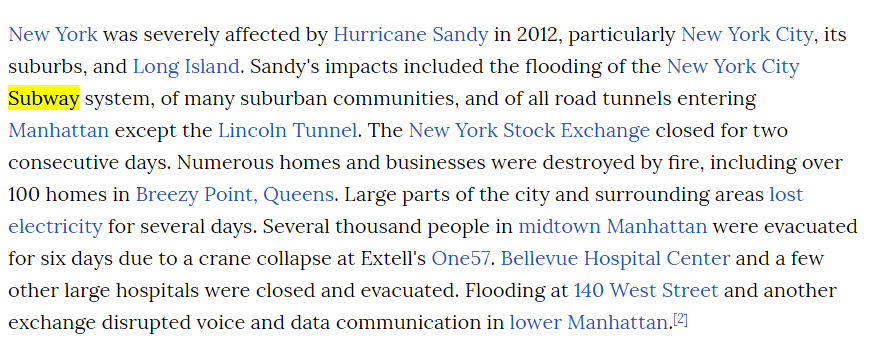

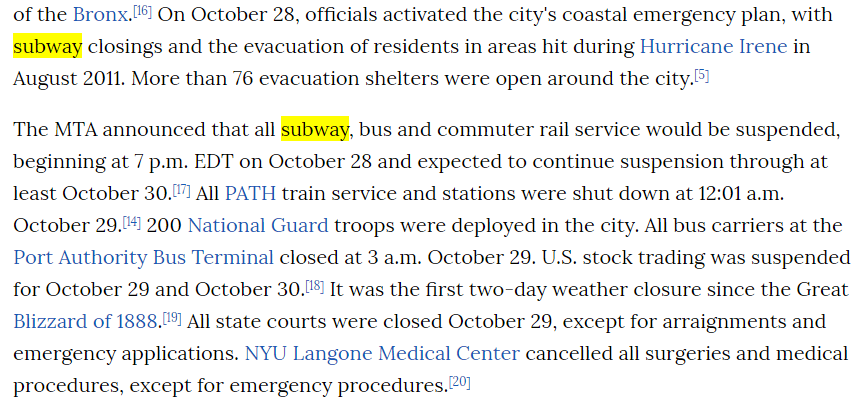

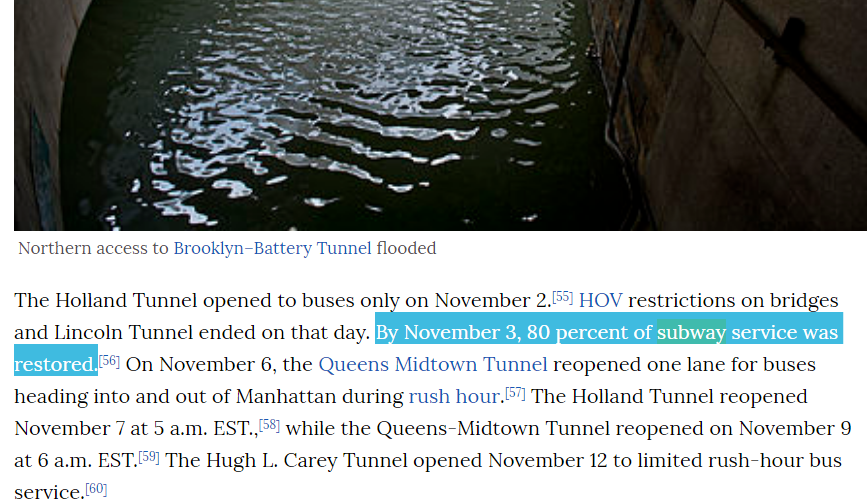

In [115]:
display(Image('news0.png', width=900, unconfined=True))
display(Image('news1.png', width=900, unconfined=True))
display(Image('news2.png', width=900, unconfined=True))

In [122]:
pd.date_range('05/21/2010','02/21/2014',freq='W-FRI')[1:-2][126]

Timestamp('2012-10-26 00:00:00', freq='W-FRI')

In [123]:
mtaRidesPerWeek.index = pd.date_range('05/21/2010','02/21/2014',freq='W-FRI')[1:-2]

In [125]:
mtaRidesPerWeek.head()

mtaRides
2010-05-28  26720267.0
2010-06-04  29265971.0
2010-06-11  29601189.0
2010-06-18  29387592.0
2010-06-25  29185768.0

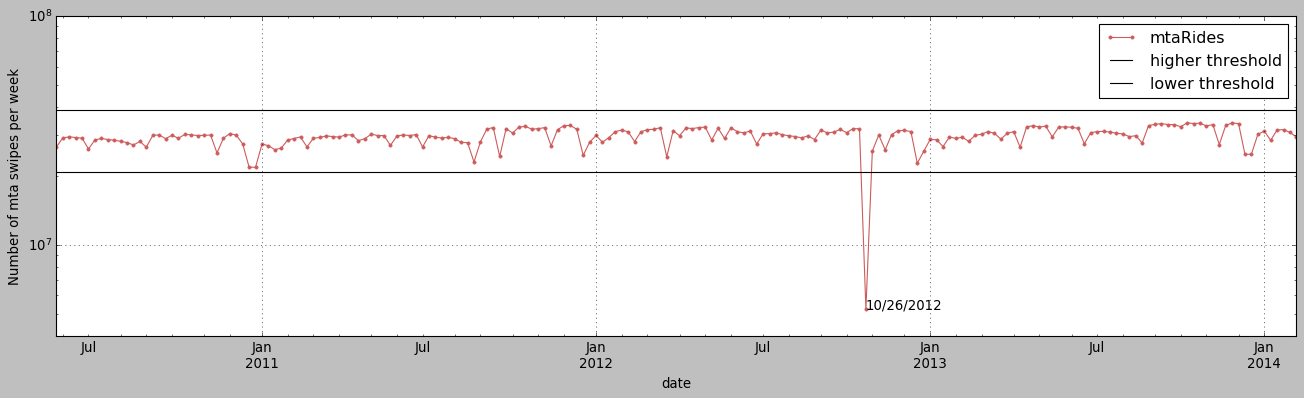

In [168]:
mtaRidesPerWeek.plot(logy=True,color='IndianRed',style='.-',figsize=(20,5))
plt.plot([plt.xlim()[0],plt.xlim()[1]],[thresholds[0],thresholds[0]],color='k',
        label='higher threshold')
plt.plot([plt.xlim()[0],plt.xlim()[1]],[thresholds[1],thresholds[1]],color='k',
        label='lower threshold')
plt.xlabel('date')
plt.ylabel('Number of mta swipes per week')
plt.ylim(4e6,plt.ylim()[1])
plt.annotate('10/26/2012',xy=[mtaRidesPerWeek[mtaRidesPerWeek.index=='2012-10-26'].index[0],
                             mtaRidesPerWeek[mtaRidesPerWeek.index=='2012-10-26'].mtaRides.values[0]])
plt.grid()
plt.legend()
plt.show()

### Figure 3. the distribution of mtaRides per week for the 194 weeks with thresholds and with the prominent date annotated

## Task 2:
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [252]:
ridershipPerWeekPerType = pd.DataFrame(np.nansum(mtaRides,axis=0).T,columns = ridetype, index = mtaRidesPerWeek.index)

In [253]:
ridershipPerWeekPerType.head()

10t       14d       1d        2t      30d         7d  \
2010-05-28  11494615.0  530524.0  47801.0  186551.0  46808.0  3697443.0   
2010-06-04  12526859.0  583533.0  51486.0  199229.0  64353.0  3981808.0   
2010-06-11  12766627.0  586194.0  51636.0  199668.0  56994.0  4033030.0   
2010-06-18  12653675.0  562602.0  52063.0  196389.0  37429.0  4032753.0   
2010-06-25  12809694.0  548858.0  51153.0  194883.0  35210.0  3925446.0   

                  ada     afas       exp        ez  ...      month       rfm  \
2010-05-28  8551937.0  10063.0  333197.0  512032.0  ...   123134.0  790110.0   
2010-06-04  9486394.0  11847.0  282755.0  578023.0  ...   151948.0  908068.0   
2010-06-11  9476538.0  12277.0  302028.0  615537.0  ...   151538.0  914124.0   
2010-06-18  9450081.0  11221.0  305513.0  606270.0  ...   147094.0  902549.0   
2010-06-25  9294002.0  10515.0  335780.0  563446.0  ...   137888.0  855573.0   

                 rr      sen   spec      tcmc        t   umlim   xbus  stud  
2010-05-28  59809.0  28221.0    0.0  124693.0  21060.0  6128.0  358.0   0.0  
2010-06-04  69209.0  32333.0    0.0  121713.0  21670.0  6120.0  474.0   0.0  
2010-06-11  69574.0  32618.0    0.0  122181.0  21433.0  6490.0  465.0   0.0  
2010-06-18  68099.0  32404.0    0.0  122051.0  21630.0  6590.0  484.0   0.0  
2010-06-25  66377.0  31933.0  176.0  119776.0  20297.0  6313.0  452.0   0.0  

[5 rows x 23 columns]

### NOTE ON THE TREND DETECTION:
#### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

#### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

#### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

#### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

In [276]:
def rollingmean(data,col):
    fig = plt.figure(figsize=(15,50))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    #rolling mean, window 10
    rmean = data[col].rolling(window=10,center=False).mean()

    ax1.plot(np.arange(len(data[col])), data[col], label="original")
    ax1.plot(np.arange(len(data[col])) - 5, rmean, label="rolling mean")
    ax1.set_title("non-stationary mean (rolling mean, window 10 dp)")
    ax1.set_xlabel("weeks")
    ax1.set_ylabel(col)
    ax1.legend()

    #rolling standard deviation, window 10
    data[col].rolling(window=10,center=False).std().plot(figsize=(15,10), 
                                         label="standard deviation",ax=ax2)
    ax2.set_title("variance (rolling stdev,window 10 dp)")
    ax2.set_xlabel("weeks")
    ax2.set_ylabel(col)
    ax2.legend()

    print ('For '+col+"\n", 
       data[col].dropna().head(), "\n", 
       data[col].dropna().tail())
    print('the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is {}'.\
         format(np.sum(data[col].dropna().head(10))/np.sum(data[col].dropna().tail(10))))
    print ("For rolling mean of {}\n".format(col), 
       data[col].rolling(window=10,center=False).mean().dropna().head(), "\n", 
       data[col].rolling(window=10,center=False).mean().dropna().tail())
    print('the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is {}'.\
         format(np.sum(data[col].rolling(window=10,center=False).mean().dropna().head(10))/np.\
                sum(data[col].rolling(window=10,center=False).mean().dropna().tail(10))))
    plt.suptitle('Ridership Type: '+col)
    plt.show()
    #plt.tight_layout()
    print('\n')

For 10t
 2010-05-28    11494615.0
2010-06-04    12526859.0
2010-06-11    12766627.0
2010-06-18    12653675.0
2010-06-25    12809694.0
Freq: W-FRI, Name: 10t, dtype: float64 
 2014-01-10    11932970.0
2014-01-17    13139360.0
2014-01-24    13189610.0
2014-01-31    12500756.0
2014-02-07    12459947.0
Freq: W-FRI, Name: 10t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.978667087302
For rolling mean of 10t
 2010-07-30    12347326.1
2010-08-06    12438021.8
2010-08-13    12413400.0
2010-08-20    12328087.8
2010-08-27    12301901.5
Freq: W-FRI, Name: 10t, dtype: float64 
 2014-01-10    12784792.4
2014-01-17    12756491.7
2014-01-24    12918506.7
2014-01-31    12794971.1
2014-02-07    12616472.2
Freq: W-FRI, Name: 10t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.952452228578


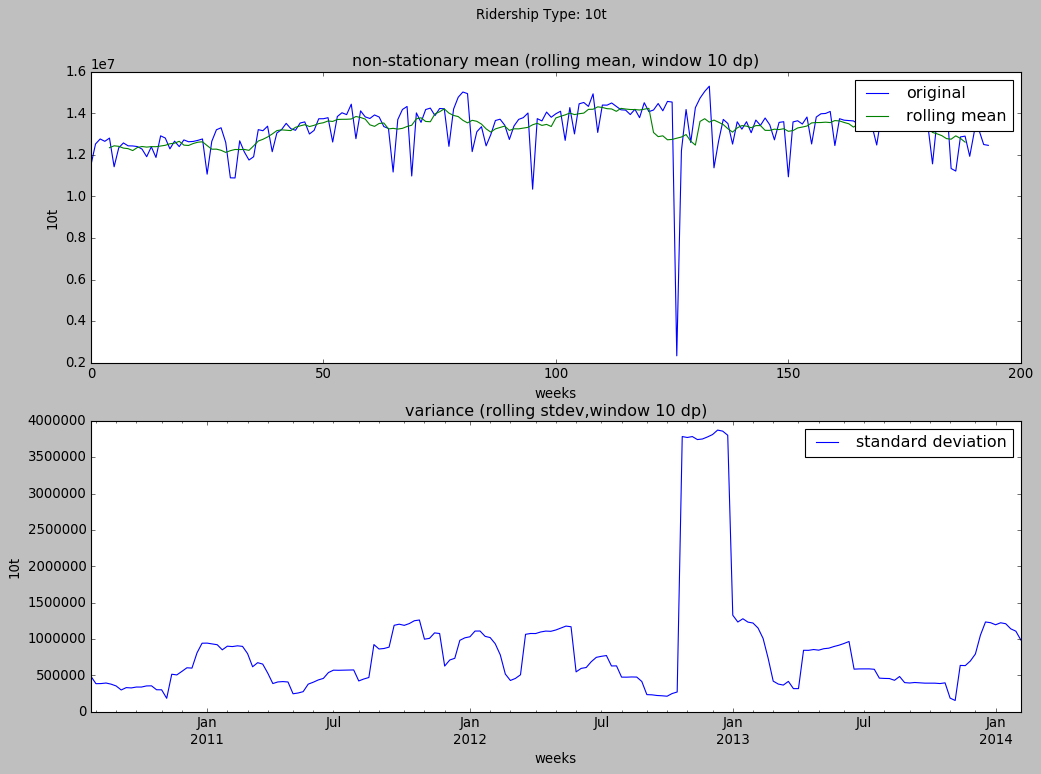



For 14d
 2010-05-28    530524.0
2010-06-04    583533.0
2010-06-11    586194.0
2010-06-18    562602.0
2010-06-25    548858.0
Freq: W-FRI, Name: 14d, dtype: float64 
 2014-01-10    613294.0
2014-01-17    713717.0
2014-01-24    695134.0
2014-01-31    670228.0
2014-02-07    679497.0
Freq: W-FRI, Name: 14d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.79868054602
For rolling mean of 14d
 2010-07-30    533376.2
2010-08-06    532186.0
2010-08-13    525801.8
2010-08-20    516787.3
2010-08-27    511925.8
Freq: W-FRI, Name: 14d, dtype: float64 
 2014-01-10    691998.4
2014-01-17    683817.6
2014-01-24    692278.2
2014-01-31    678913.9
2014-02-07    667821.7
Freq: W-FRI, Name: 14d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.740122953921


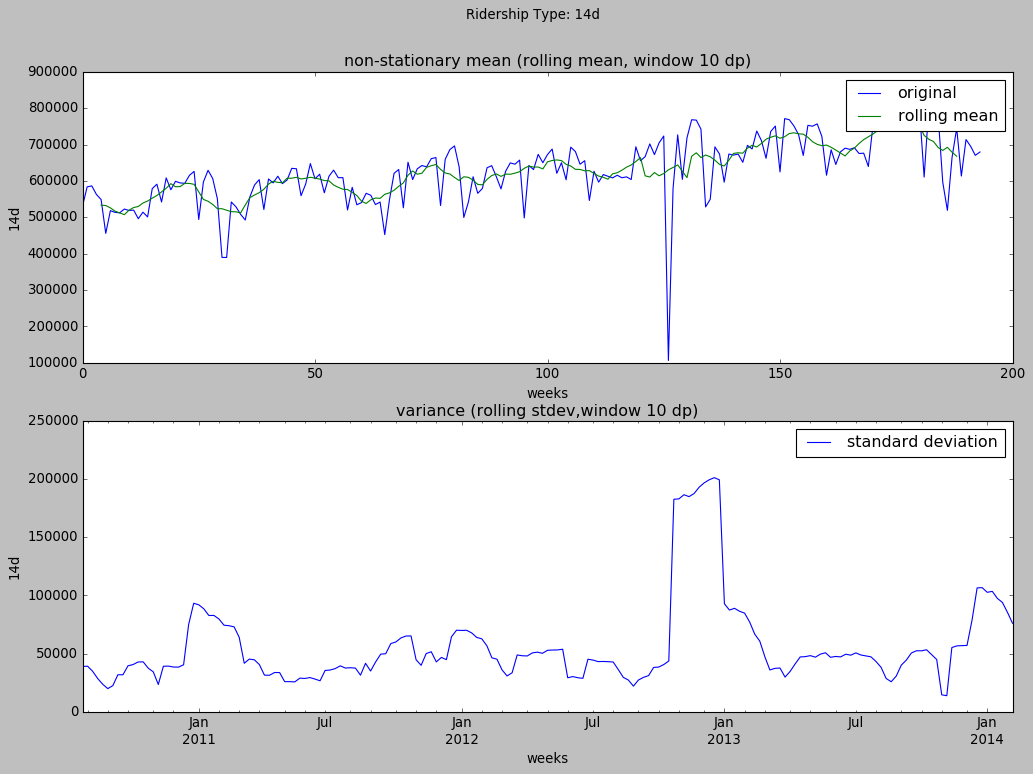



For 1d
 2010-05-28    47801.0
2010-06-04    51486.0
2010-06-11    51636.0
2010-06-18    52063.0
2010-06-25    51153.0
Freq: W-FRI, Name: 1d, dtype: float64 
 2014-01-10    51664.0
2014-01-17    57208.0
2014-01-24    58771.0
2014-01-31    56525.0
2014-02-07    55192.0
Freq: W-FRI, Name: 1d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.899810476622
For rolling mean of 1d
 2010-07-30    49898.9
2010-08-06    50014.6
2010-08-13    49727.9
2010-08-20    49310.8
2010-08-27    49105.8
Freq: W-FRI, Name: 1d, dtype: float64 
 2014-01-10    57259.0
2014-01-17    56608.7
2014-01-24    57244.2
2014-01-31    56377.4
2014-02-07    55454.9
Freq: W-FRI, Name: 1d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.846900792067


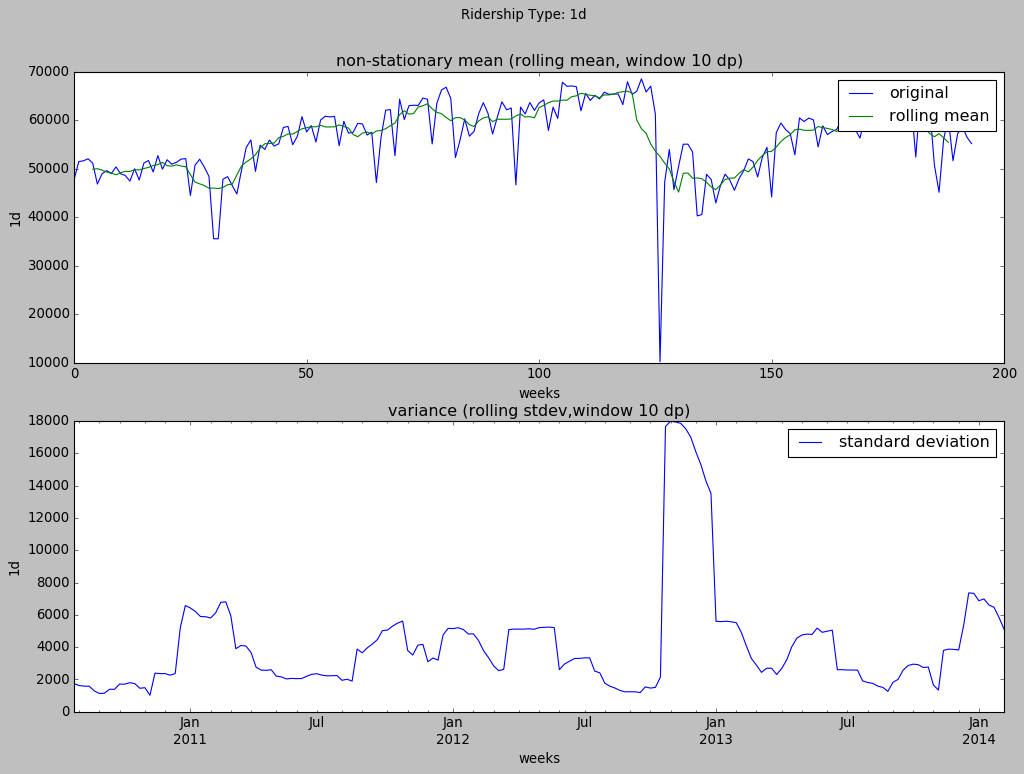



For 2t
 2010-05-28    186551.0
2010-06-04    199229.0
2010-06-11    199668.0
2010-06-18    196389.0
2010-06-25    194883.0
Freq: W-FRI, Name: 2t, dtype: float64 
 2014-01-10    168932.0
2014-01-17    189564.0
2014-01-24    184239.0
2014-01-31    180029.0
2014-02-07    179363.0
Freq: W-FRI, Name: 2t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.07088927164
For rolling mean of 2t
 2010-07-30    190627.5
2010-08-06    190856.4
2010-08-13    189699.8
2010-08-20    187936.9
2010-08-27    186858.1
Freq: W-FRI, Name: 2t, dtype: float64 
 2014-01-10    181911.2
2014-01-17    180559.5
2014-01-24    181912.8
2014-01-31    179860.5
2014-02-07    178008.6
Freq: W-FRI, Name: 2t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.01746328396


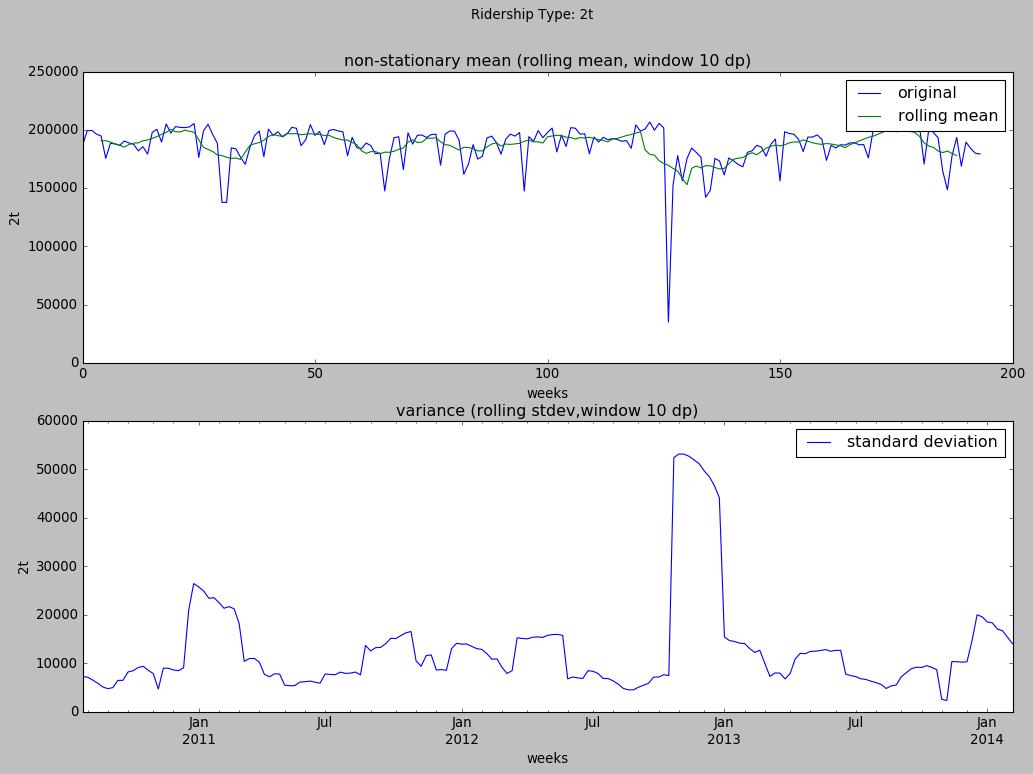



For 30d
 2010-05-28    46808.0
2010-06-04    64353.0
2010-06-11    56994.0
2010-06-18    37429.0
2010-06-25    35210.0
Freq: W-FRI, Name: 30d, dtype: float64 
 2014-01-10    43426.0
2014-01-17    47804.0
2014-01-24    61101.0
2014-01-31    59400.0
2014-02-07    46859.0
Freq: W-FRI, Name: 30d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.967317176485
For rolling mean of 30d
 2010-07-30    47956.2
2010-08-06    48741.4
2010-08-13    46724.4
2010-08-20    43959.0
2010-08-27    43932.1
Freq: W-FRI, Name: 30d, dtype: float64 
 2014-01-10    49784.2
2014-01-17    49070.7
2014-01-24    52127.3
2014-01-31    51639.6
2014-02-07    49576.5
Freq: W-FRI, Name: 30d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.893978927983


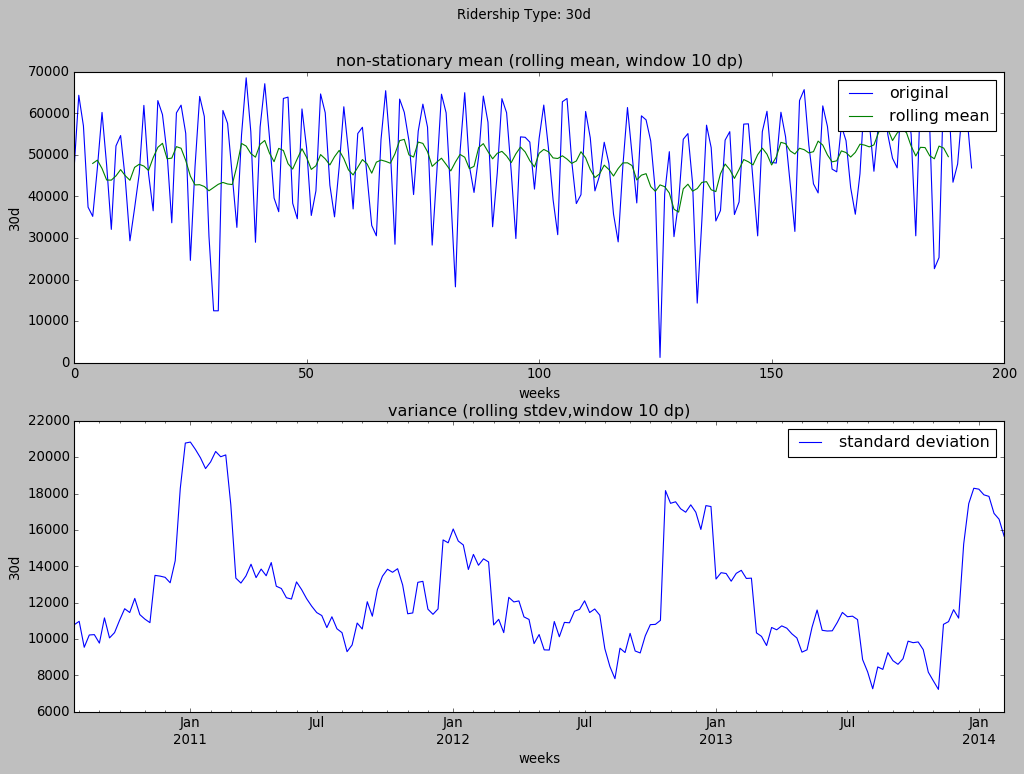



For 7d
 2010-05-28    3697443.0
2010-06-04    3981808.0
2010-06-11    4033030.0
2010-06-18    4032753.0
2010-06-25    3925446.0
Freq: W-FRI, Name: 7d, dtype: float64 
 2014-01-10    4970067.0
2014-01-17    5511613.0
2014-01-24    5599237.0
2014-01-31    5551292.0
2014-02-07    5405077.0
Freq: W-FRI, Name: 7d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.719555117345
For rolling mean of 7d
 2010-07-30    3934303.6
2010-08-06    3970926.0
2010-08-13    3974298.6
2010-08-20    3966722.6
2010-08-27    3963185.5
Freq: W-FRI, Name: 7d, dtype: float64 
 2014-01-10    5632153.0
2014-01-17    5580362.6
2014-01-24    5625637.5
2014-01-31    5573354.8
2014-02-07    5467689.0
Freq: W-FRI, Name: 7d, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.693391364325


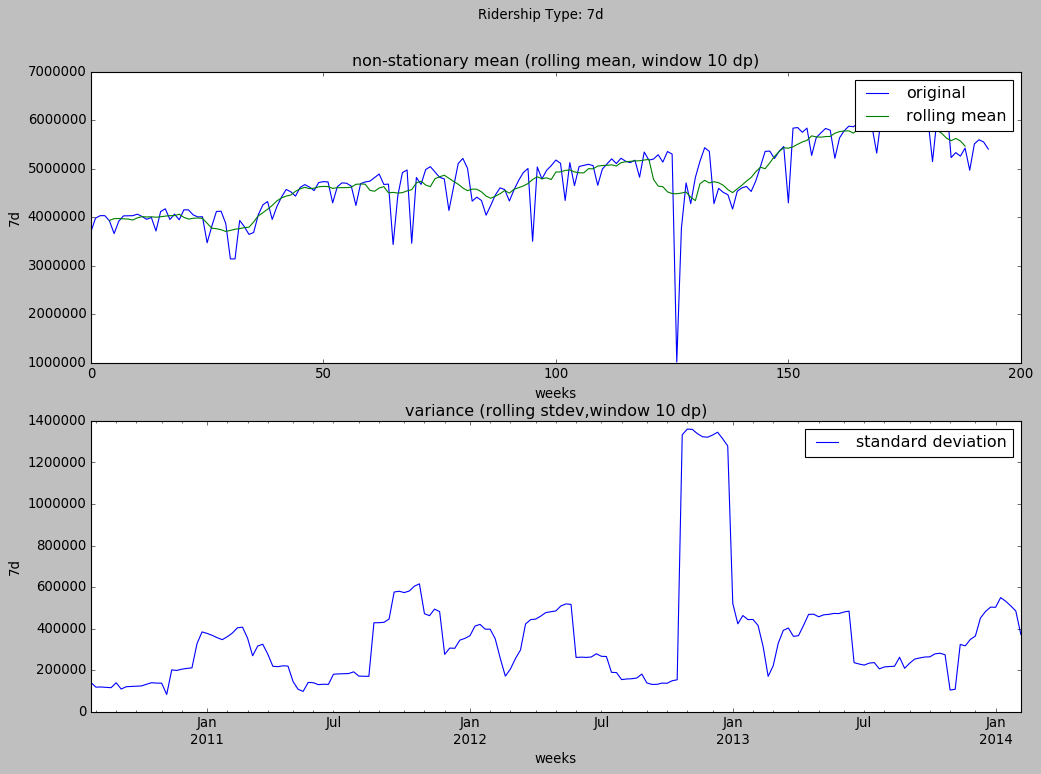



For ada
 2010-05-28    8551937.0
2010-06-04    9486394.0
2010-06-11    9476538.0
2010-06-18    9450081.0
2010-06-25    9294002.0
Freq: W-FRI, Name: ada, dtype: float64 
 2014-01-10    8250357.0
2014-01-17    9446638.0
2014-01-24    9309259.0
2014-01-31    9030595.0
2014-02-07    8705150.0
Freq: W-FRI, Name: ada, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.11130702032
For rolling mean of ada
 2010-07-30    9117571.2
2010-08-06    9124481.8
2010-08-13    9022678.5
2010-08-20    8915251.8
2010-08-27    8851225.3
Freq: W-FRI, Name: ada, dtype: float64 
 2014-01-10    8080450.4
2014-01-17    8053298.5
2014-01-24    8234697.6
2014-01-31    8233333.2
2014-02-07    8204367.5
Freq: W-FRI, Name: ada, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.06742132304


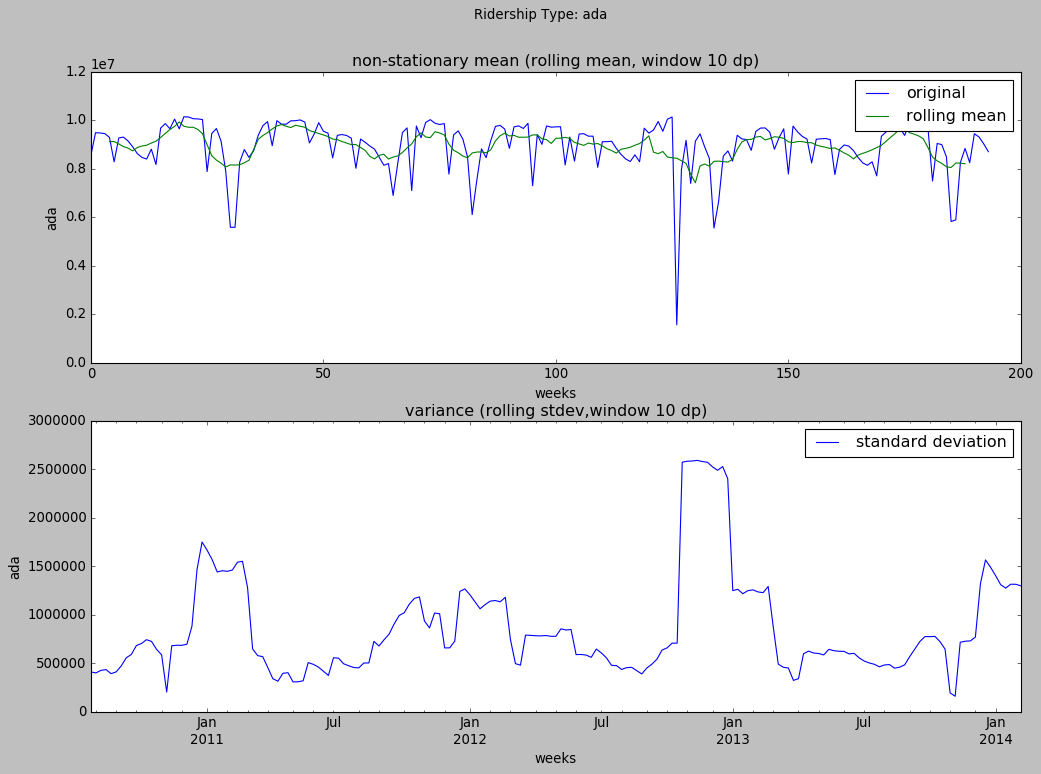



For afas
 2010-05-28    10063.0
2010-06-04    11847.0
2010-06-11    12277.0
2010-06-18    11221.0
2010-06-25    10515.0
Freq: W-FRI, Name: afas, dtype: float64 
 2014-01-10    2.0
2014-01-17    2.0
2014-01-24    2.0
2014-01-31    3.0
2014-02-07    0.0
Freq: W-FRI, Name: afas, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 4774.47826087
For rolling mean of afas
 2010-07-30    10981.3
2010-08-06    11057.6
2010-08-13    10942.7
2010-08-20    10725.4
2010-08-27    10580.2
Freq: W-FRI, Name: afas, dtype: float64 
 2014-01-10    2.4
2014-01-17    2.4
2014-01-24    2.2
2014-01-31    2.4
2014-02-07    2.3
Freq: W-FRI, Name: afas, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 4823.78026906


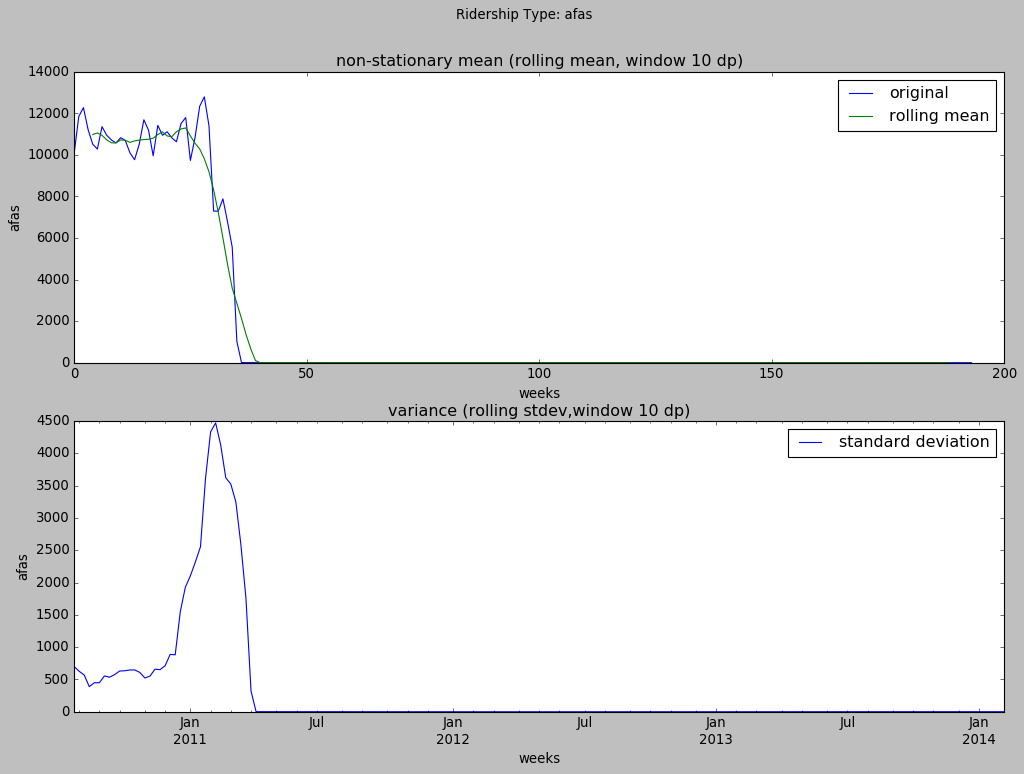



For exp
 2010-05-28    333197.0
2010-06-04    282755.0
2010-06-11    302028.0
2010-06-18    305513.0
2010-06-25    335780.0
Freq: W-FRI, Name: exp, dtype: float64 
 2014-01-10    2.0
2014-01-17    6.0
2014-01-24    0.0
2014-01-31    5.0
2014-02-07    3.0
Freq: W-FRI, Name: exp, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 93571.3428571
For rolling mean of exp
 2010-07-30    327499.7
2010-08-06    329921.7
2010-08-13    337337.3
2010-08-20    339234.3
2010-08-27    338819.6
Freq: W-FRI, Name: exp, dtype: float64 
 2014-01-10    3.4
2014-01-17    3.6
2014-01-24    3.4
2014-01-31    3.6
2014-02-07    3.5
Freq: W-FRI, Name: exp, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 94866.7557471


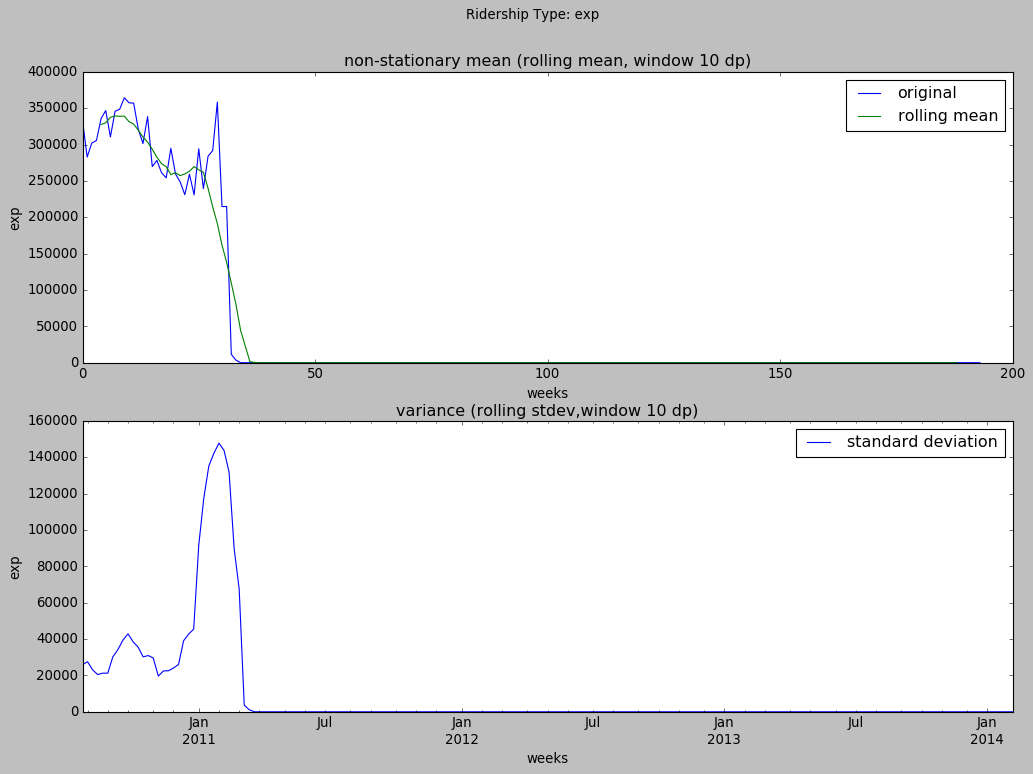



For ez
 2010-05-28    512032.0
2010-06-04    578023.0
2010-06-11    615537.0
2010-06-18    606270.0
2010-06-25    563446.0
Freq: W-FRI, Name: ez, dtype: float64 
 2014-01-10    0.0
2014-01-17    1.0
2014-01-24    3.0
2014-01-31    0.0
2014-02-07    1.0
Freq: W-FRI, Name: ez, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 665798.555556
For rolling mean of ez
 2010-07-30    599218.7
2010-08-06    614143.4
2010-08-13    619018.1
2010-08-20    615071.9
2010-08-27    610441.1
Freq: W-FRI, Name: ez, dtype: float64 
 2014-01-10    0.9
2014-01-17    0.8
2014-01-24    1.0
2014-01-31    1.0
2014-02-07    0.9
Freq: W-FRI, Name: ez, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 511771.302521


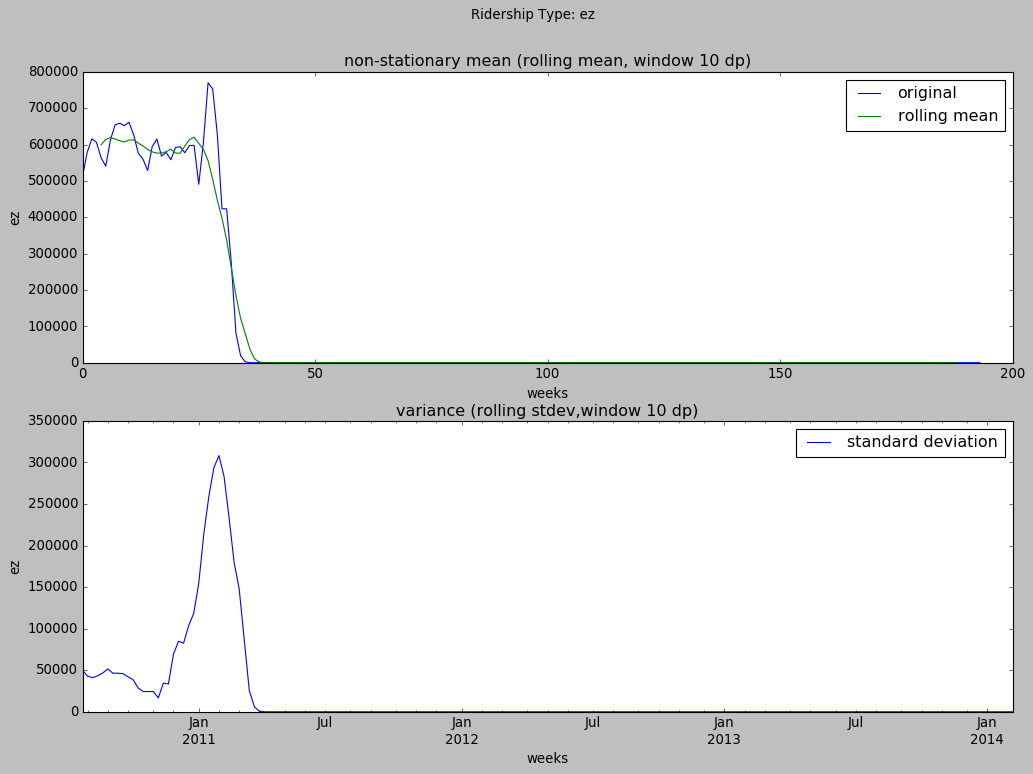



For ff
 2010-05-28    35898.0
2010-06-04    44577.0
2010-06-11    45842.0
2010-06-18    44271.0
2010-06-25    41636.0
Freq: W-FRI, Name: ff, dtype: float64 
 2014-01-10    32794.0
2014-01-17    39380.0
2014-01-24    39216.0
2014-01-31    36145.0
2014-02-07    32138.0
Freq: W-FRI, Name: ff, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.22129628533
For rolling mean of ff
 2010-07-30    41254.9
2010-08-06    41790.3
2010-08-13    41331.0
2010-08-20    40723.5
2010-08-27    40303.7
Freq: W-FRI, Name: ff, dtype: float64 
 2014-01-10    34167.4
2014-01-17    33828.8
2014-01-24    35225.6
2014-01-31    34834.7
2014-02-07    33779.6
Freq: W-FRI, Name: ff, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.14974870405


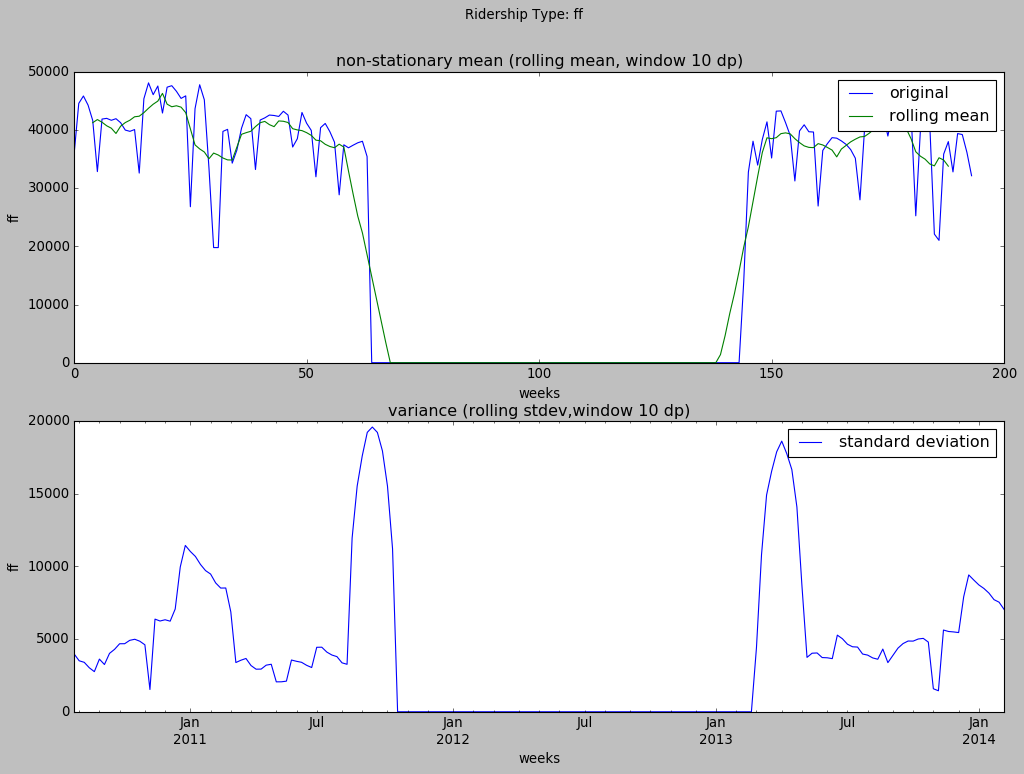



For mc
 2010-05-28    119881.0
2010-06-04    143569.0
2010-06-11    136383.0
2010-06-18    134418.0
2010-06-25    136351.0
Freq: W-FRI, Name: mc, dtype: float64 
 2014-01-10    158766.0
2014-01-17    180918.0
2014-01-24    181019.0
2014-01-31    168950.0
2014-02-07    152362.0
Freq: W-FRI, Name: mc, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.824035088267
For rolling mean of mc
 2010-07-30    131889.7
2010-08-06    132944.0
2010-08-13    131174.8
2010-08-20    129916.9
2010-08-27    129063.0
Freq: W-FRI, Name: mc, dtype: float64 
 2014-01-10    158433.4
2014-01-17    159013.6
2014-01-24    164556.4
2014-01-31    163531.2
2014-02-07    160053.5
Freq: W-FRI, Name: mc, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.800016285018


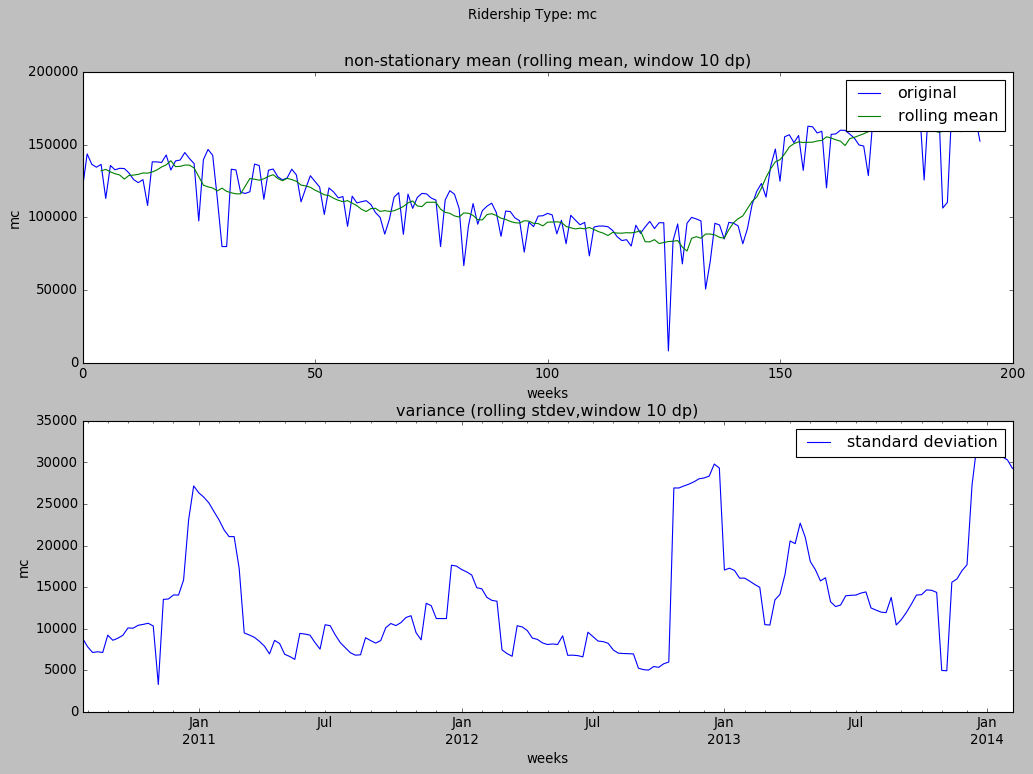



For mr
 2010-05-28     4.0
2010-06-04     3.0
2010-06-11    12.0
2010-06-18     6.0
2010-06-25     9.0
Freq: W-FRI, Name: mr, dtype: float64 
 2014-01-10    126325.0
2014-01-17    144746.0
2014-01-24    152864.0
2014-01-31    142804.0
2014-02-07    146353.0
Freq: W-FRI, Name: mr, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 4.03470963308e-05
For rolling mean of mr
 2010-07-30    5.8
2010-08-06    5.6
2010-08-13    6.0
2010-08-20    5.2
2010-08-27    5.1
Freq: W-FRI, Name: mr, dtype: float64 
 2014-01-10    149666.4
2014-01-17    147507.1
2014-01-24    148937.8
2014-01-31    145479.8
2014-02-07    143752.6
Freq: W-FRI, Name: mr, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 3.14285246599e-05


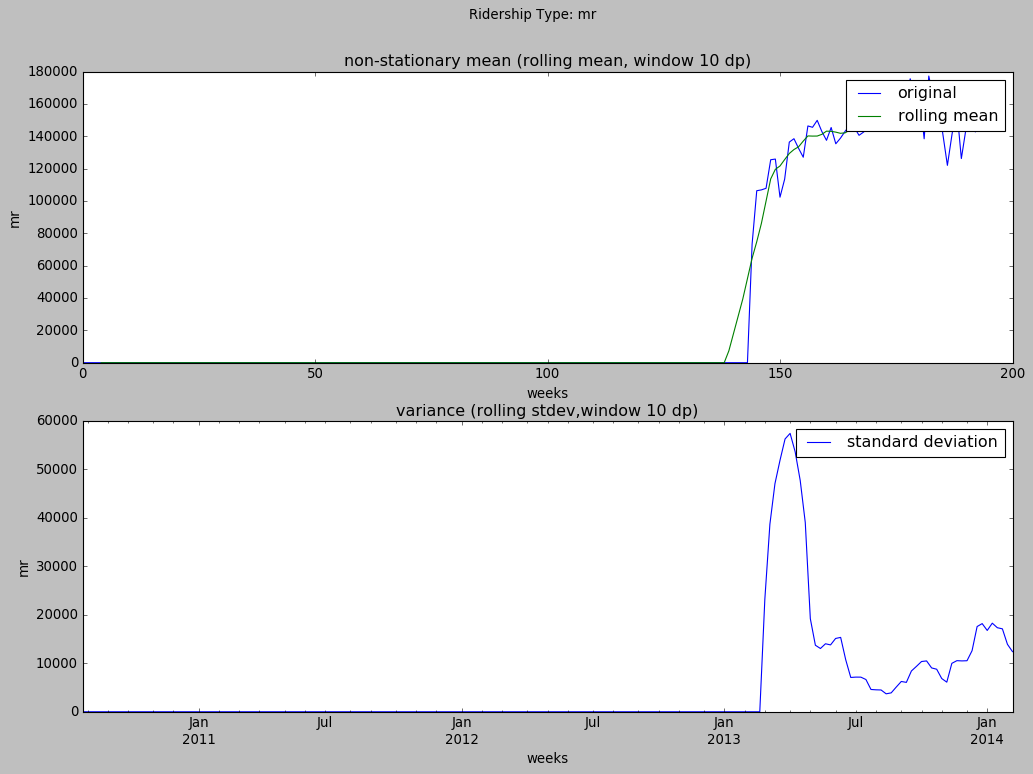



For month
 2010-05-28    123134.0
2010-06-04    151948.0
2010-06-11    151538.0
2010-06-18    147094.0
2010-06-25    137888.0
Freq: W-FRI, Name: month, dtype: float64 
 2014-01-10    73993.0
2014-01-17    97828.0
2014-01-24    87308.0
2014-01-31    82733.0
2014-02-07    74272.0
Freq: W-FRI, Name: month, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.72794422105
For rolling mean of month
 2010-07-30    137296.4
2010-08-06    138431.2
2010-08-13    136185.4
2010-08-20    133147.9
2010-08-27    131111.0
Freq: W-FRI, Name: month, dtype: float64 
 2014-01-10    79957.3
2014-01-17    79996.3
2014-01-24    82798.5
2014-01-31    81647.3
2014-02-07    79456.5
Freq: W-FRI, Name: month, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.61963327143


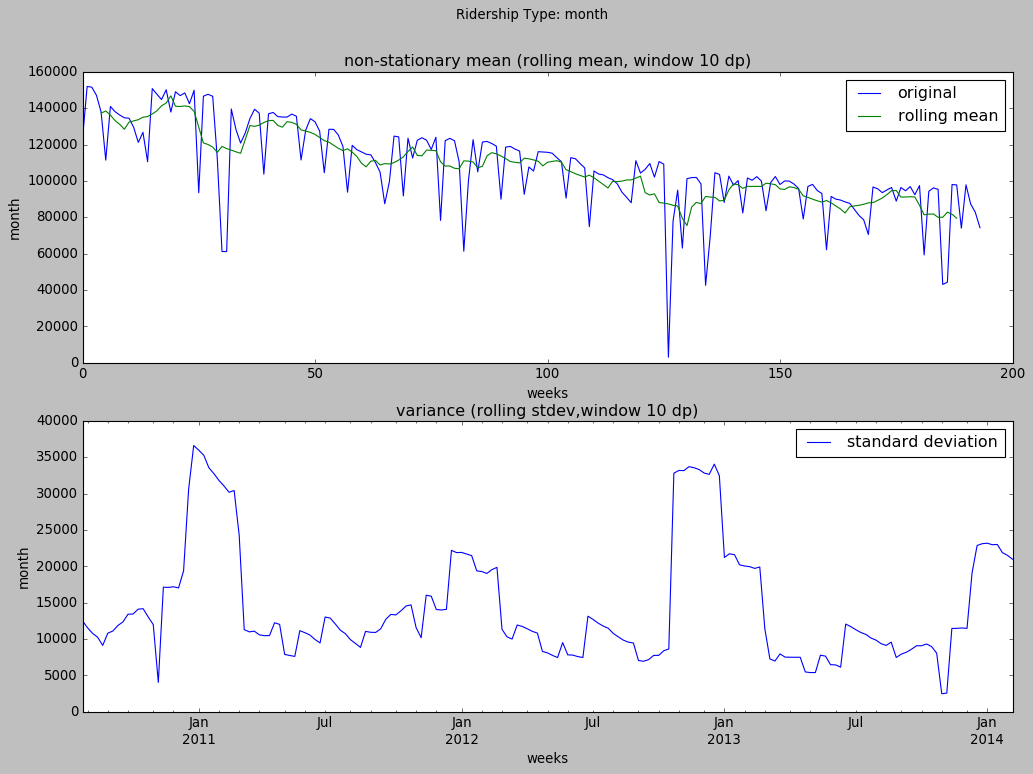



For rfm
 2010-05-28    790110.0
2010-06-04    908068.0
2010-06-11    914124.0
2010-06-18    902549.0
2010-06-25    855573.0
Freq: W-FRI, Name: rfm, dtype: float64 
 2014-01-10    541263.0
2014-01-17    607106.0
2014-01-24    606189.0
2014-01-31    590849.0
2014-02-07    552006.0
Freq: W-FRI, Name: rfm, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.53938888675
For rolling mean of rfm
 2010-07-30    844028.3
2010-08-06    846704.1
2010-08-13    836627.0
2010-08-20    824119.7
2010-08-27    815964.5
Freq: W-FRI, Name: rfm, dtype: float64 
 2014-01-10    536784.2
2014-01-17    538027.8
2014-01-24    554020.3
2014-01-31    554425.8
2014-02-07    548287.9
Freq: W-FRI, Name: rfm, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.51211386668


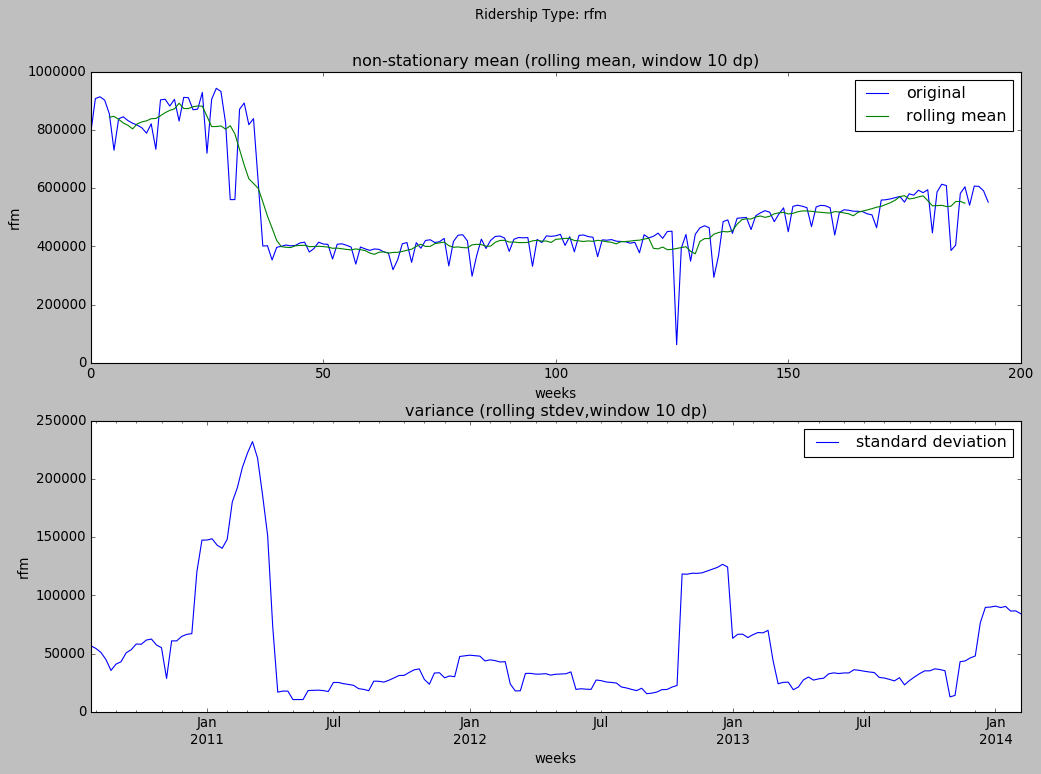



For rr
 2010-05-28    59809.0
2010-06-04    69209.0
2010-06-11    69574.0
2010-06-18    68099.0
2010-06-25    66377.0
Freq: W-FRI, Name: rr, dtype: float64 
 2014-01-10    163216.0
2014-01-17    194920.0
2014-01-24    188230.0
2014-01-31    179707.0
2014-02-07    170854.0
Freq: W-FRI, Name: rr, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.385659649203
For rolling mean of rr
 2010-07-30    64516.0
2010-08-06    64826.2
2010-08-13    64197.5
2010-08-20    63383.3
2010-08-27    63007.3
Freq: W-FRI, Name: rr, dtype: float64 
 2014-01-10    164927.4
2014-01-17    165525.7
2014-01-24    170863.3
2014-01-31    170285.6
2014-02-07    167287.4
Freq: W-FRI, Name: rr, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.380139499192


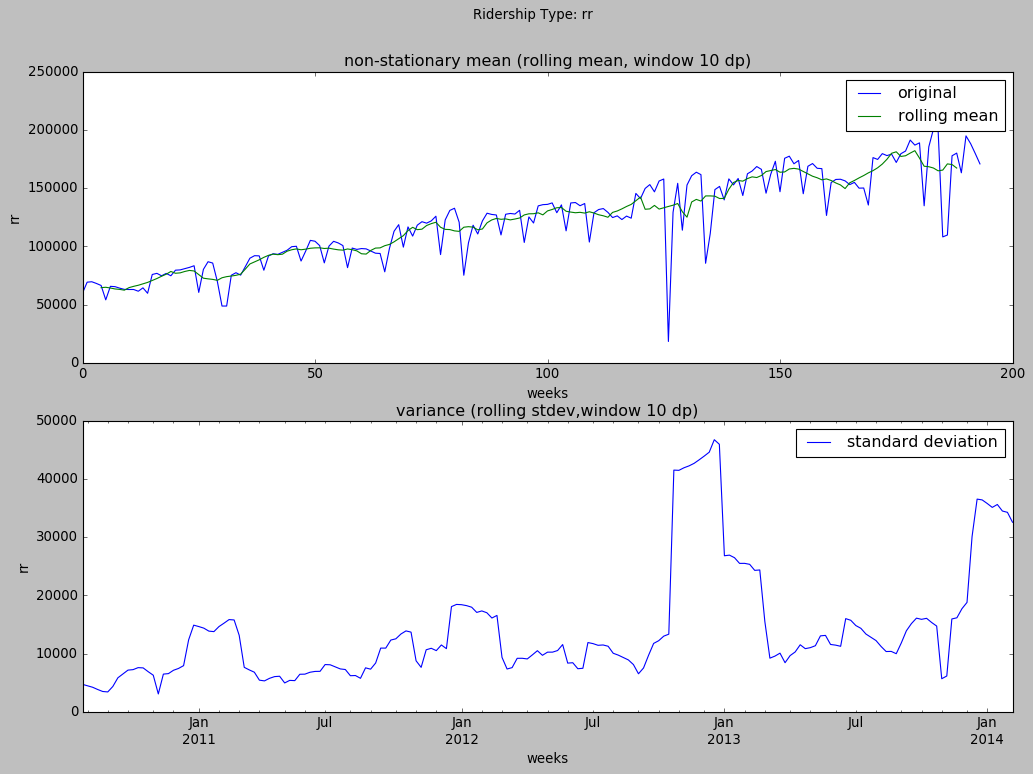



For sen
 2010-05-28    28221.0
2010-06-04    32333.0
2010-06-11    32618.0
2010-06-18    32404.0
2010-06-25    31933.0
Freq: W-FRI, Name: sen, dtype: float64 
 2014-01-10     89354.0
2014-01-17    103961.0
2014-01-24    102124.0
2014-01-31    101071.0
2014-02-07     96887.0
Freq: W-FRI, Name: sen, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.343713862169
For rolling mean of sen
 2010-07-30    31208.6
2010-08-06    31525.9
2010-08-13    31426.6
2010-08-20    31322.8
2010-08-27    31417.4
Freq: W-FRI, Name: sen, dtype: float64 
 2014-01-10    88764.8
2014-01-17    88805.6
2014-01-24    91572.1
2014-01-31    91689.8
2014-02-07    90798.2
Freq: W-FRI, Name: sen, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.35132281524


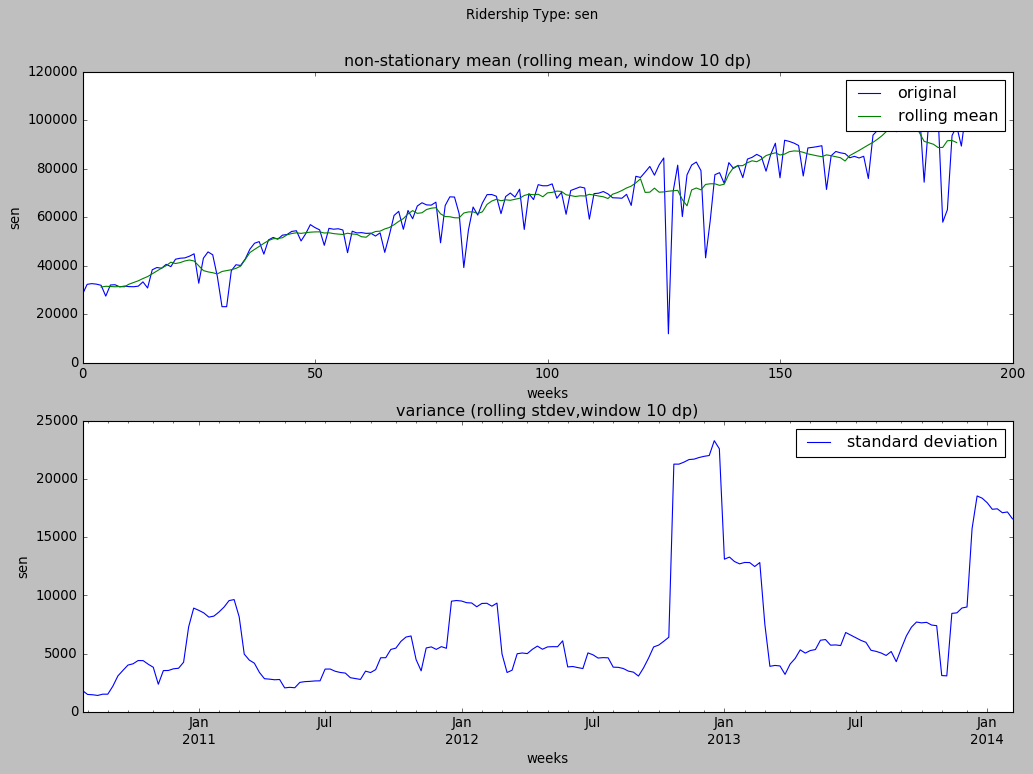



For spec
 2010-05-28      0.0
2010-06-04      0.0
2010-06-11      0.0
2010-06-18      0.0
2010-06-25    176.0
Freq: W-FRI, Name: spec, dtype: float64 
 2014-01-10    25304.0
2014-01-17    28836.0
2014-01-24    30882.0
2014-01-31    24702.0
2014-02-07    26509.0
Freq: W-FRI, Name: spec, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.0142485908332
For rolling mean of spec
 2010-07-30     454.0
2010-08-06    1740.9
2010-08-13    3128.6
2010-08-20    4197.9
2010-08-27    5515.0
Freq: W-FRI, Name: spec, dtype: float64 
 2014-01-10    34488.8
2014-01-17    34166.4
2014-01-24    33841.5
2014-01-31    32833.4
2014-02-07    31862.8
Freq: W-FRI, Name: spec, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.184072162821


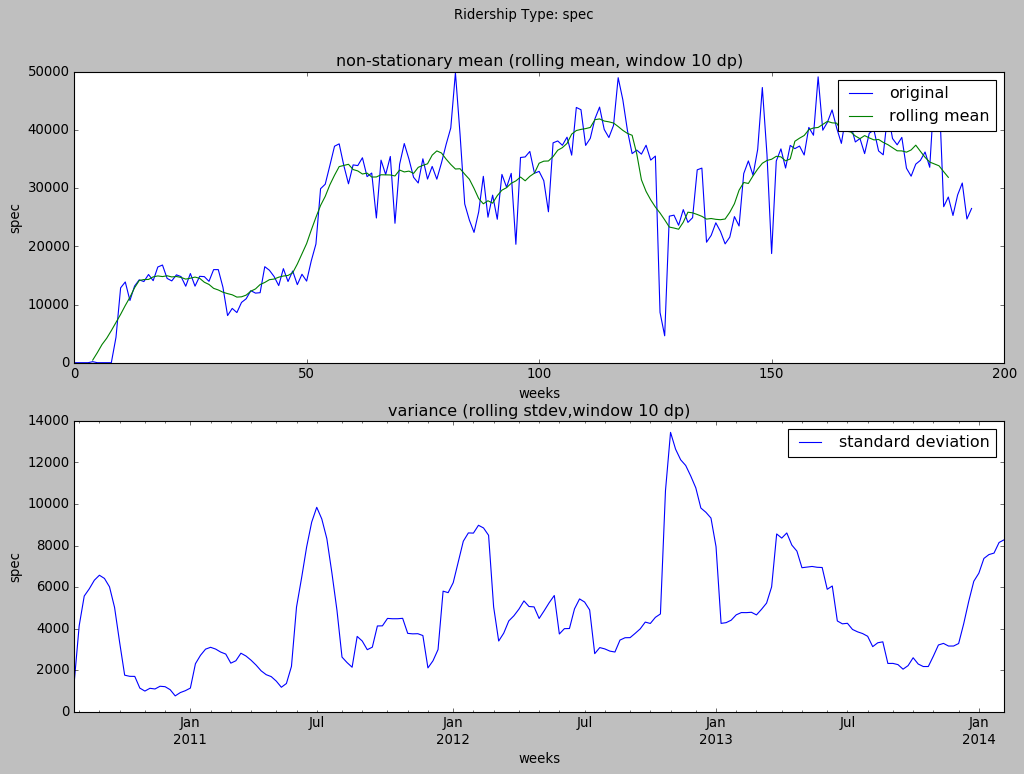



For tcmc
 2010-05-28    124693.0
2010-06-04    121713.0
2010-06-11    122181.0
2010-06-18    122051.0
2010-06-25    119776.0
Freq: W-FRI, Name: tcmc, dtype: float64 
 2014-01-10    139163.0
2014-01-17    138907.0
2014-01-24    170980.0
2014-01-31    168923.0
2014-02-07    186362.0
Freq: W-FRI, Name: tcmc, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.652626042706
For rolling mean of tcmc
 2010-07-30    120860.6
2010-08-06    120940.9
2010-08-13    121945.7
2010-08-20    122751.3
2010-08-27    124538.5
Freq: W-FRI, Name: tcmc, dtype: float64 
 2014-01-10    199910.4
2014-01-17    194654.4
2014-01-24    191531.8
2014-01-31    187831.8
2014-02-07    185191.2
Freq: W-FRI, Name: tcmc, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.631541760567


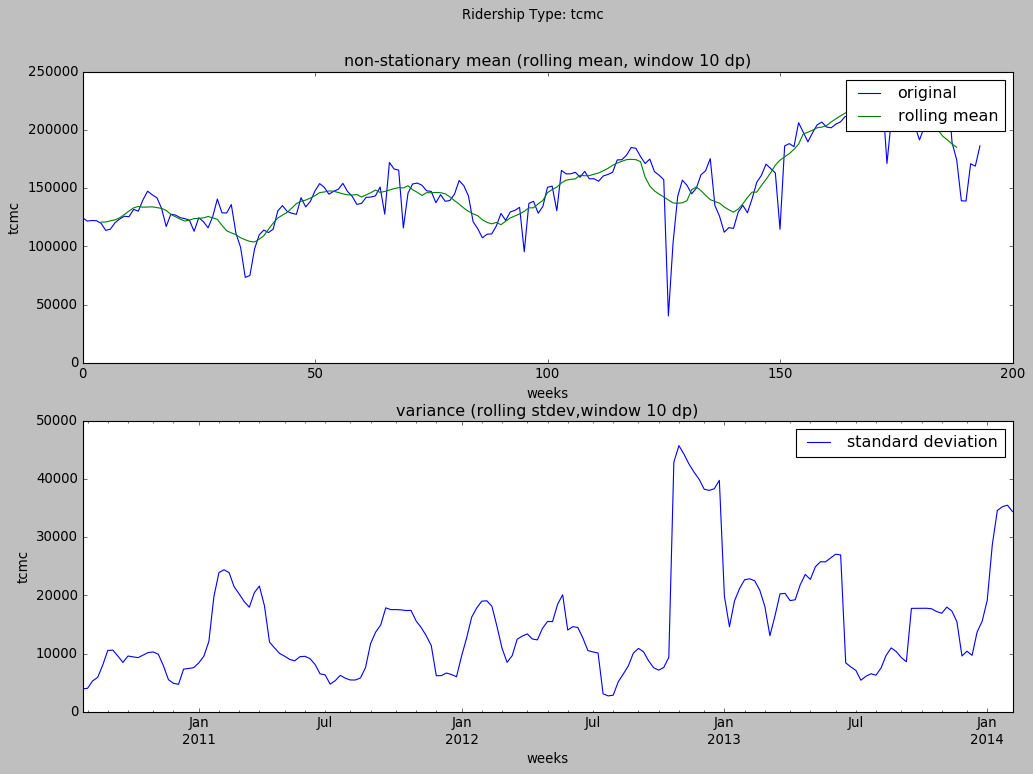



For t
 2010-05-28    21060.0
2010-06-04    21670.0
2010-06-11    21433.0
2010-06-18    21630.0
2010-06-25    20297.0
Freq: W-FRI, Name: t, dtype: float64 
 2014-01-10    10106.0
2014-01-17    18249.0
2014-01-24    23409.0
2014-01-31    23736.0
2014-02-07    24467.0
Freq: W-FRI, Name: t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.978867204328
For rolling mean of t
 2010-07-30    21131.1
2010-08-06    21176.8
2010-08-13    21167.9
2010-08-20    21167.1
2010-08-27    21173.3
Freq: W-FRI, Name: t, dtype: float64 
 2014-01-10    21852.0
2014-01-17    21390.1
2014-01-24    21526.9
2014-01-31    21524.1
2014-02-07    21587.3
Freq: W-FRI, Name: t, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.94852740346


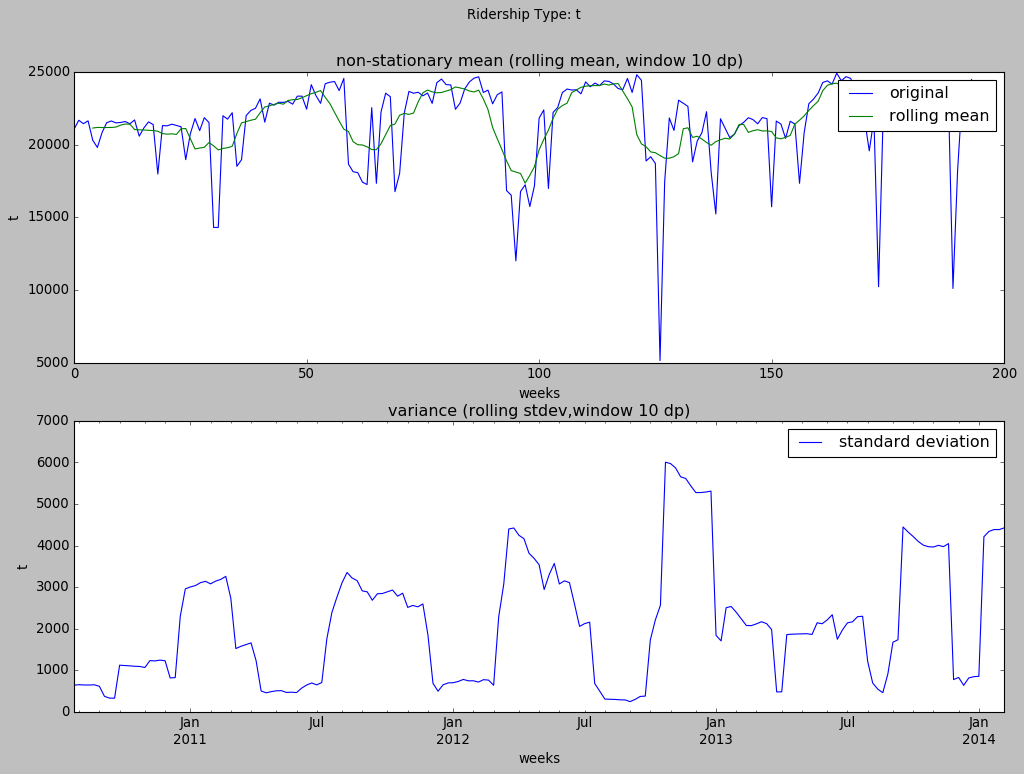



For umlim
 2010-05-28    6128.0
2010-06-04    6120.0
2010-06-11    6490.0
2010-06-18    6590.0
2010-06-25    6313.0
Freq: W-FRI, Name: umlim, dtype: float64 
 2014-01-10    2299.0
2014-01-17    4065.0
2014-01-24    5398.0
2014-01-31    5759.0
2014-02-07    6184.0
Freq: W-FRI, Name: umlim, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.23599634403
For rolling mean of umlim
 2010-07-30    6626.3
2010-08-06    6756.1
2010-08-13    6878.3
2010-08-20    6934.6
2010-08-27    6963.0
Freq: W-FRI, Name: umlim, dtype: float64 
 2014-01-10    5458.6
2014-01-17    5339.3
2014-01-24    5339.8
2014-01-31    5325.5
2014-02-07    5361.1
Freq: W-FRI, Name: umlim, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 1.23365577797


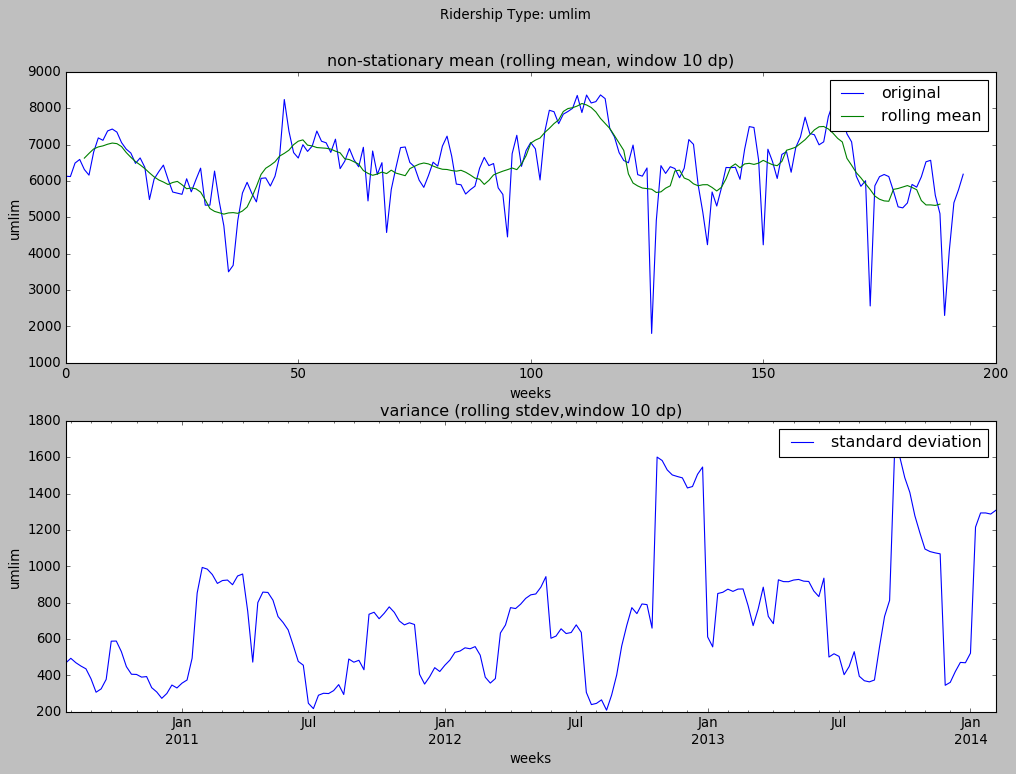



For xbus
 2010-05-28    358.0
2010-06-04    474.0
2010-06-11    465.0
2010-06-18    484.0
2010-06-25    452.0
Freq: W-FRI, Name: xbus, dtype: float64 
 2014-01-10    212.0
2014-01-17    772.0
2014-01-24    862.0
2014-01-31    810.0
2014-02-07    820.0
Freq: W-FRI, Name: xbus, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.601566447701
For rolling mean of xbus
 2010-07-30    476.2
2010-08-06    489.8
2010-08-13    489.0
2010-08-20    480.1
2010-08-27    477.8
Freq: W-FRI, Name: xbus, dtype: float64 
 2014-01-10    877.5
2014-01-17    847.2
2014-01-24    849.7
2014-01-31    821.1
2014-02-07    791.6
Freq: W-FRI, Name: xbus, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.525908982503


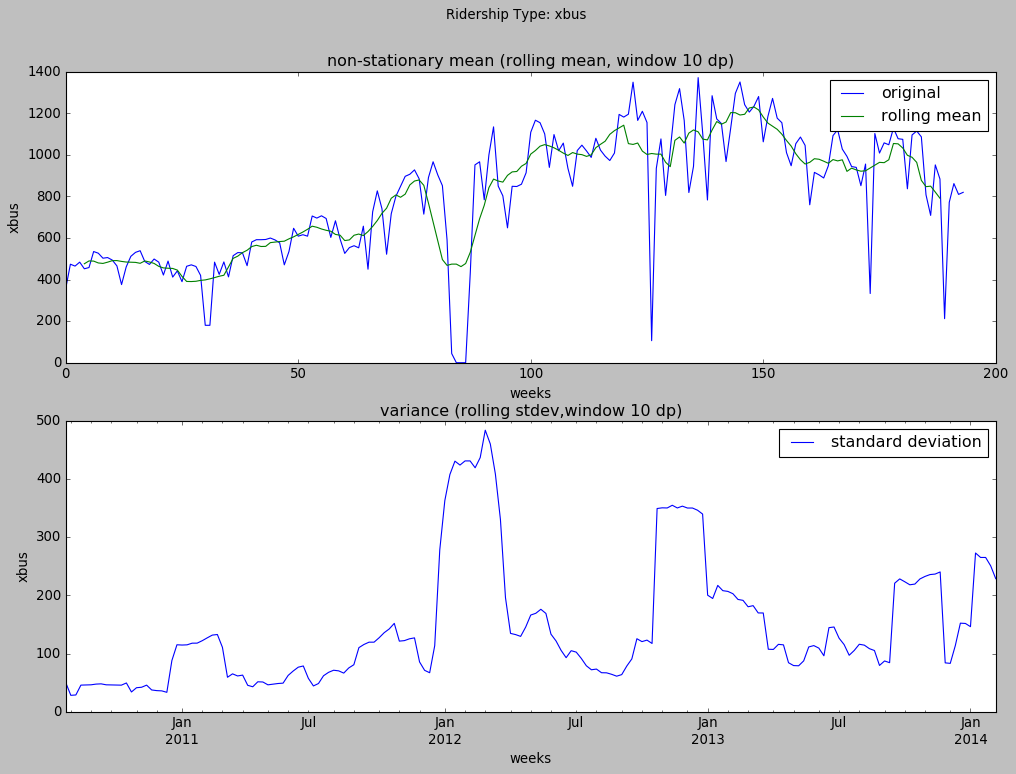



For stud
 2010-05-28    0.0
2010-06-04    0.0
2010-06-11    0.0
2010-06-18    0.0
2010-06-25    0.0
Freq: W-FRI, Name: stud, dtype: float64 
 2014-01-10    1182107.0
2014-01-17    1050160.0
2014-01-24    1132723.0
2014-01-31    1379403.0
2014-02-07     535018.0
Freq: W-FRI, Name: stud, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.0
For rolling mean of stud
 2010-07-30    0.0
2010-08-06    0.0
2010-08-13    0.0
2010-08-20    0.0
2010-08-27    0.0
Freq: W-FRI, Name: stud, dtype: float64 
 2014-01-10    1229125.7
2014-01-17    1176480.6
2014-01-24    1186881.3
2014-01-31    1169743.8
2014-02-07    1068539.6
Freq: W-FRI, Name: stud, dtype: float64
the ratio of the number of 10 rides near the beginning to the number of 10 rides near the end of the time series is 0.0


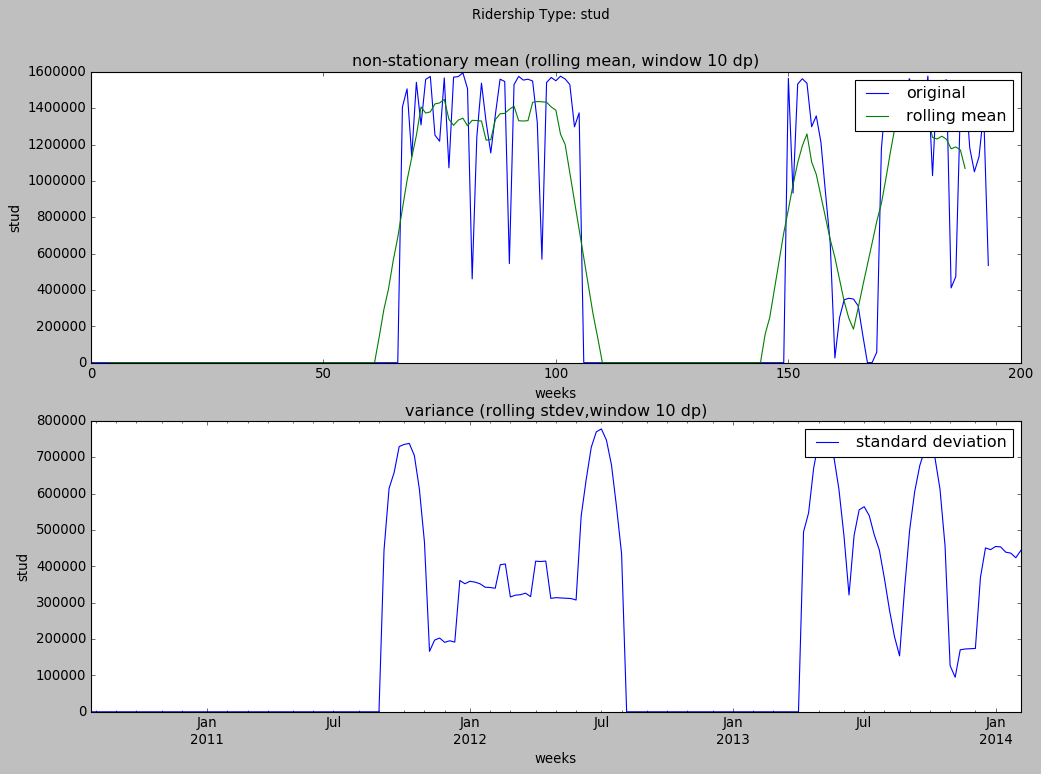

In [277]:
for column in ridershipPerWeekPerType.columns:
    rollingmean(ridershipPerWeekPerType,column)

### Figure 4. Plots of the riderships by type after rolling mean and std by 10 windows. We could see that ridership by type: 14d, 7d, rr and sen have steadily increased with respective ratios of 0.76726433042, 0.710545442577, 0.38137363519 and 0.34741077053 and ridership by type: month has steadily diminished with respective ratio of 1.67429001285

## Task 3: 
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [266]:
ridershipPerStationPerWeek = pd.DataFrame(np.nansum(mtaRides,axis=1).T,index = mtaRidesPerWeek.index)

In [271]:
ridershipPerStationPerWeek.head()

0        1       2        3        4        5        6    \
2010-05-28  126878.0  37306.0  6606.0  16378.0  18564.0  19987.0  12449.0   
2010-06-04  149477.0  46464.0  6881.0  17408.0  19903.0  20625.0  13644.0   
2010-06-11  152383.0  49359.0  7229.0  17595.0  19948.0  21225.0  13719.0   
2010-06-18  160175.0  44849.0  5731.0  14242.0  16076.0  17412.0  11460.0   
2010-06-25  162641.0  41509.0  7032.0  17589.0  20283.0  20909.0  14094.0   

                7        8         9   ...   590  591  592  593  594  595  \
2010-05-28  11091.0  10482.0  147187.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-04  11659.0  11030.0  154826.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-11  12037.0  10881.0  155958.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-18   9809.0   9123.0  154914.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-25  11944.0  10923.0  157628.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   

            596  597  598  599  
2010-05-28  0.0  0.0  0.0  0.0  
2010-06-04  0.0  0.0  0.0  0.0  
2010-06-11  0.0  0.0  0.0  0.0  
2010-06-18  0.0  0.0  0.0  0.0  
2010-06-25  0.0  0.0  0.0  0.0  

[5 rows x 600 columns]

C:\Users\sddz0\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


Text(0.5,1,u'Trash pickup power spectrum')

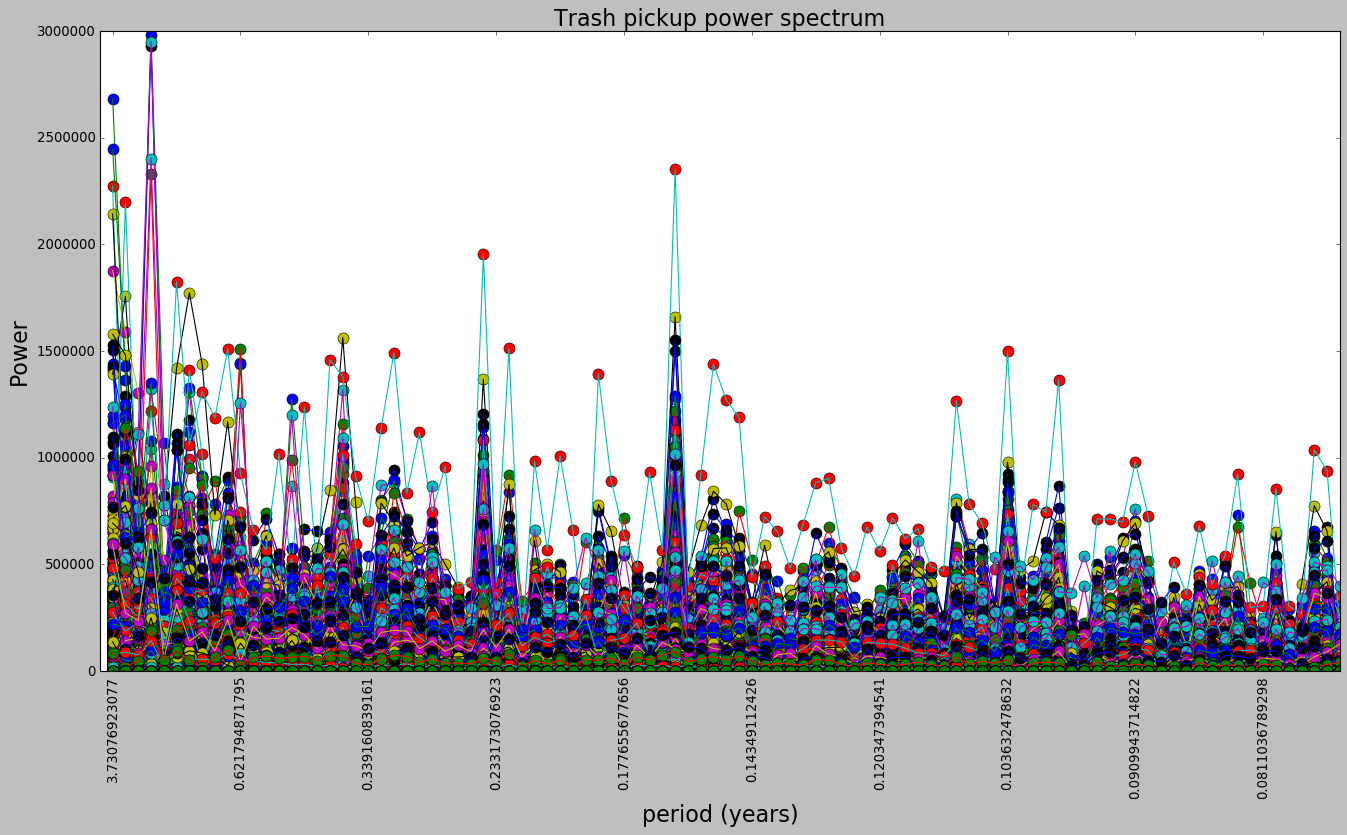

In [317]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
N = len(ridershipPerStationPerWeek.index)
allperiods = []
for column in ridershipPerStationPerWeek.columns:
    f = np.abs(np.fft.rfft(ridershipPerStationPerWeek[column]))
    allperiods.append(1/f)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

ax.set_xticks(np.fft.rfftfreq(N, 1.0)[1:][::10])
ax.set_xticklabels([ "%s"%(1/52./f) for f in np.fft.rfftfreq(N, 1.0)[1:][::5]], rotation=90)
ax.set_xlabel("period (years)", fontsize=20)
ax.set_ylabel("Power", fontsize=20)
ax.set_title("Trash pickup power spectrum", fontsize=20)

### Figure 5. Power spectrum for all 600 stations' riderships by period(years) but there are too many lines so it would be better to zoom in    

In [320]:
1/52.

0.019230769230769232

In [324]:
np.fft.rfftfreq(N, 1.0)

array([ 0.        ,  0.00515464,  0.01030928,  0.01546392,  0.02061856,
        0.0257732 ,  0.03092784,  0.03608247,  0.04123711,  0.04639175,
        0.05154639,  0.05670103,  0.06185567,  0.06701031,  0.07216495,
        0.07731959,  0.08247423,  0.08762887,  0.09278351,  0.09793814,
        0.10309278,  0.10824742,  0.11340206,  0.1185567 ,  0.12371134,
        0.12886598,  0.13402062,  0.13917526,  0.1443299 ,  0.14948454,
        0.15463918,  0.15979381,  0.16494845,  0.17010309,  0.17525773,
        0.18041237,  0.18556701,  0.19072165,  0.19587629,  0.20103093,
        0.20618557,  0.21134021,  0.21649485,  0.22164948,  0.22680412,
        0.23195876,  0.2371134 ,  0.24226804,  0.24742268,  0.25257732,
        0.25773196,  0.2628866 ,  0.26804124,  0.27319588,  0.27835052,
        0.28350515,  0.28865979,  0.29381443,  0.29896907,  0.30412371,
        0.30927835,  0.31443299,  0.31958763,  0.32474227,  0.32989691,
        0.33505155,  0.34020619,  0.34536082,  0.35051546,  0.35

C:\Users\sddz0\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


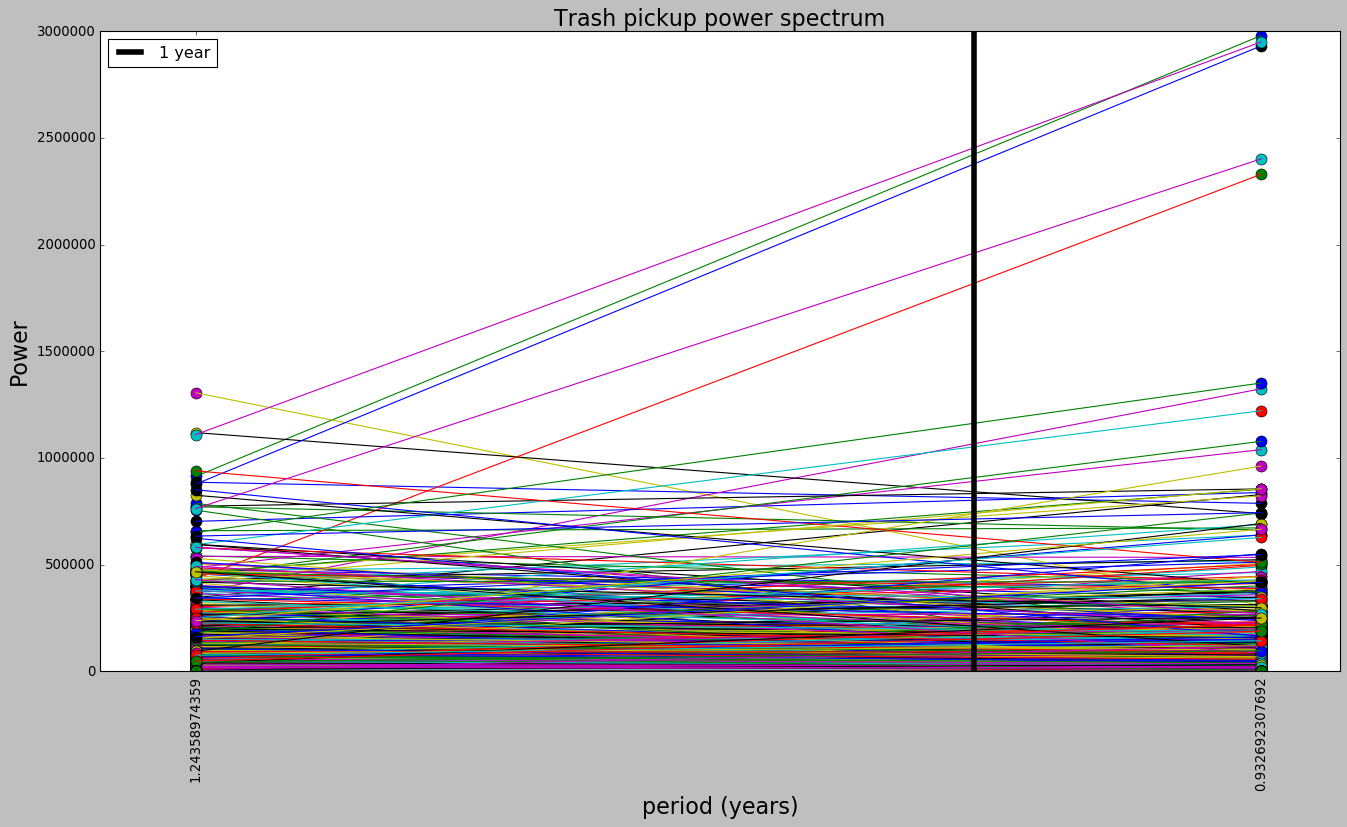

In [379]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
N = len(ridershipPerStationPerWeek.index)
powerlist = {}
for column in ridershipPerStationPerWeek.columns:
    f = np.abs(np.fft.rfft(ridershipPerStationPerWeek[column]))
    allperiods.append(1/f)
    ax.plot(np.fft.rfftfreq(N, 1.0)[3:5], (f[3:5]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[3:5], (f[3:5]), '-')
    powerlist[column] = f[4]
    
ax.plot([1.0/52,1.0/52],ax.get_ylim(),color='k',lw=5.0,label='1 year')
idx = np.argwhere(np.diff(np.sign(1 - np.fft.rfftfreq(N, 1.0)[3:5])))
ax.set_xticks(np.fft.rfftfreq(N, 1.0)[3:5])
ax.set_xticklabels([ "%s"%(1/52./f) for f in np.fft.rfftfreq(N, 1.0)[3:5]], rotation=90)
ax.set_xlabel("period (years)", fontsize=20)
ax.set_ylabel("Power", fontsize=20)
ax.set_title("Trash pickup power spectrum", fontsize=20)
ax.legend(loc='upper left')

### Figure 6. Power spectrum for all 600 stations' riderships between period(years) 0.9327 and 1.2436. In this plot we could easily find the 4 stations that show the most prominent periodic trend on an annual period but the specific station index is still unknown

In [397]:
sorted(powerlist.items(), key=lambda x:x[1],reverse=True)[:5]

[(0, 2980160.6355953491),
 (194, 2950388.929214194),
 (150, 2931895.8769513387),
 (327, 2402218.5809588572),
 (32, 2329896.5813884311)]

## As at period = 1 year, the first two is reverse as at period = 0.932692 year so the 4 stations that show the most prominent periodic trend on an annual period are station 194, 0, 150 and 327

Text(0.5,0.98,u'ridership for the 4 stations that show the most prominent periodic trend on an annual period')

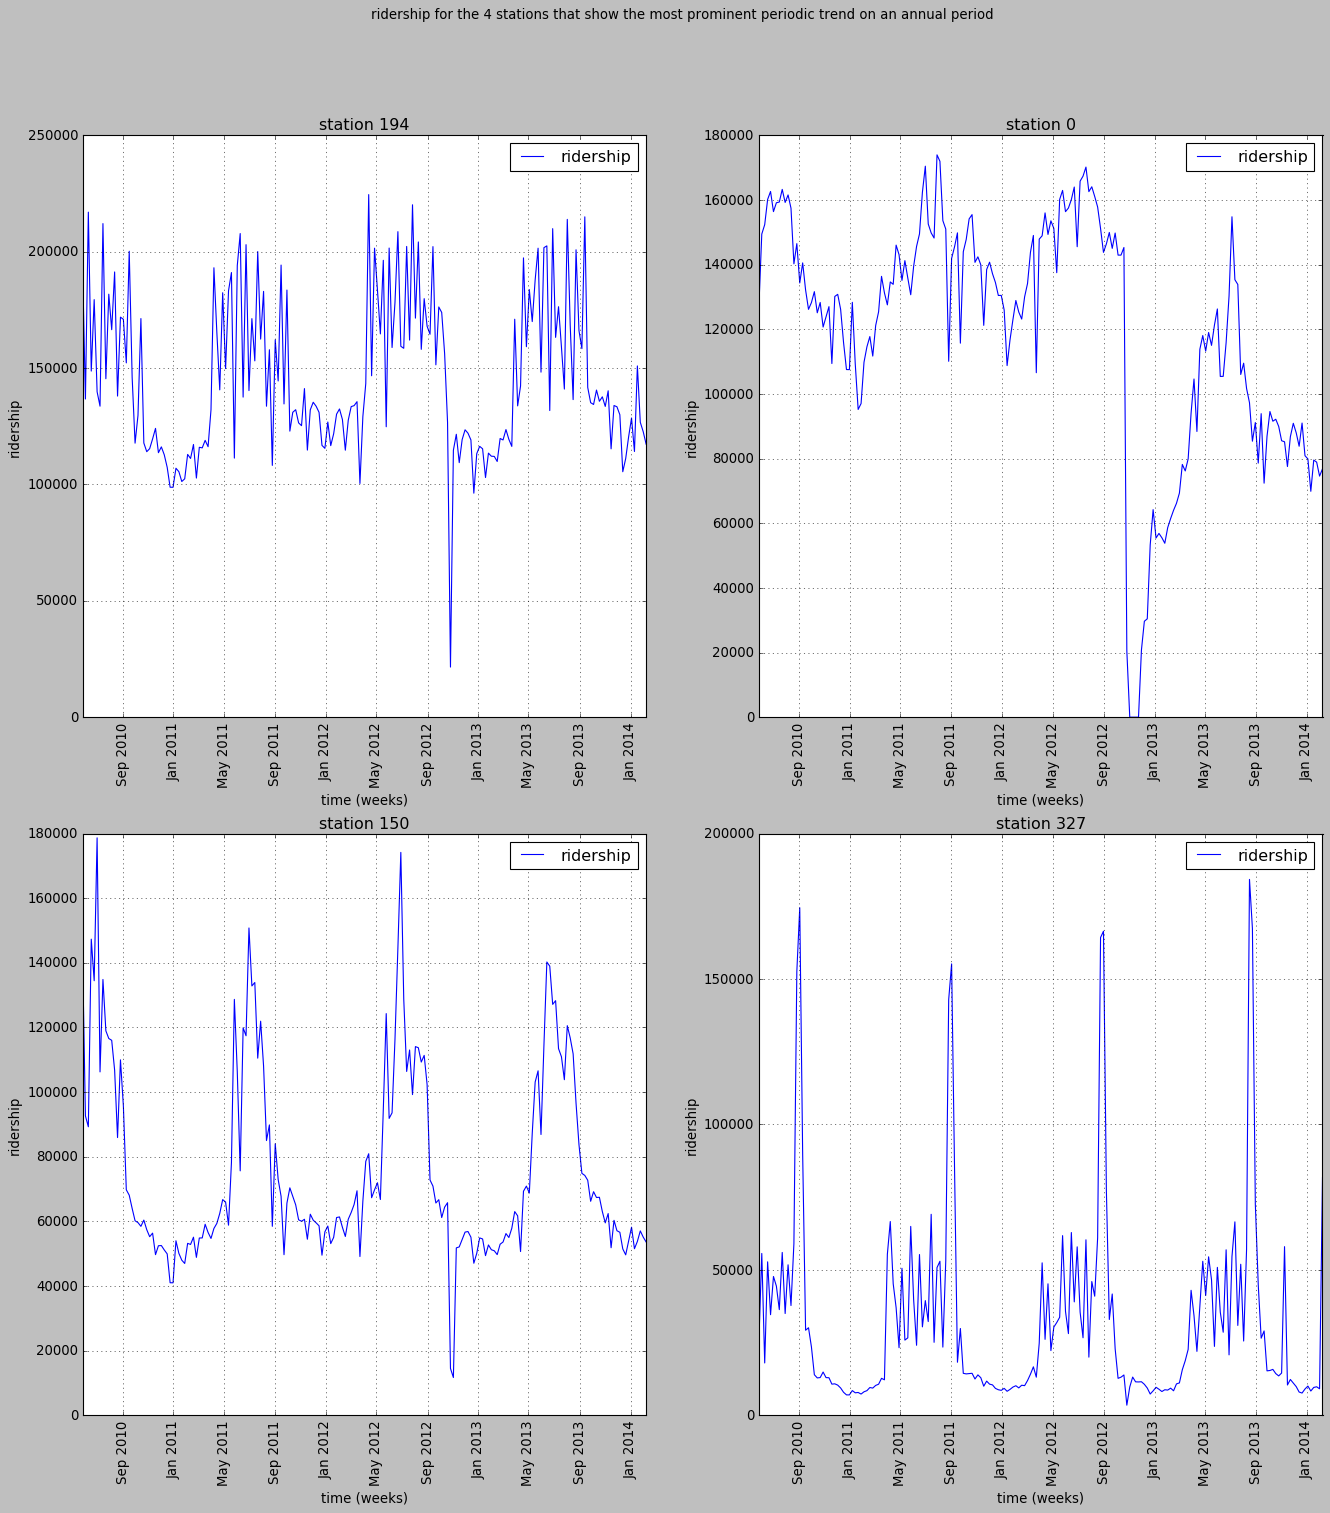

In [419]:
fig = plt.figure(figsize=(20,20))
stations = [194,0,150,327]
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(ridershipPerStationPerWeek.iloc[:,stations[i]],label='ridership')
    ax.grid()
    ax.set_xlabel('time (weeks)')
    ax.set_ylabel('ridership')
    ax.set_title('station {}'.format(stations[i]))
    ax.legend()
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
fig.suptitle('ridership for the 4 stations that show the most prominent periodic trend on an annual period')

### Figure 7. ridership for the 4 stations that show the most prominent periodic trend on an annual period

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

In [513]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T

In [514]:
tots.shape

(13800L, 194L)

In [515]:
tots = tots[tots.std(1)>0]

C:\Users\sddz0\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [516]:
tots.shape

(7660L, 194L)

In [521]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [524]:
data = pd.DataFrame(vals.T)

In [526]:
data.head()

0         1         2         3        4         5         6     \
0 -0.656406 -0.793281 -1.344229  1.095053 -0.68399 -1.127376  0.467575   
1 -0.306381 -1.206117 -1.467122  2.114439 -0.68399 -0.743041  0.467575   
2  0.204605 -0.976764 -0.606867  1.706685 -0.68399 -0.522922  0.758222   
3 -1.892991 -1.504277 -1.344229  0.687298 -0.68399 -1.602553 -0.623725   
4  0.166281 -1.183182 -1.590016  2.012501 -0.44788 -0.896775  0.588221   

       7         8         9       ...         7650      7651      7652  \
0 -0.315112  2.822067  2.143633    ...    -0.071982  1.278985 -0.071982   
1  0.499978  0.843003  2.471273    ...    -0.071982  1.839083 -0.071982   
2 -0.315112  3.181897  2.471273    ...    -0.071982  2.119132 -0.071982   
3  3.760338  1.652620  2.084062    ...    -0.071982  0.018766 -0.071982   
4  7.020699  2.372280  2.218096    ...    -0.071982 -0.121258 -0.071982   

       7653      7654      7655      7656      7657      7658      7659  
0 -0.071982  0.947503 -0.071982 -0.071982 -0.071982 -2.211459  0.168214  
1 -0.071982  2.145000 -0.071982 -0.071982 -0.071982 -2.211459 -0.854043  
2 -0.071982  1.801274 -0.071982 -0.071982 -0.071982 -2.211459 -1.148925  
3 -0.071982  1.612779 -0.071982 -0.071982 -0.071982 -2.211459 -0.401891  
4 -0.071982  1.612779 -0.071982 -0.071982 -0.071982 -2.197464  0.679343  

[5 rows x 7660 columns]

In [527]:
data.shape

(194, 7660)

In [532]:
km = KMeans(random_state=999, n_clusters=10)
res = km.fit(data)
labels = res.labels_

In [535]:
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 7, 8, 8, 8,
       7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 7, 1, 7, 1, 1, 1, 1, 7, 7, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4,
       4, 7, 7, 9, 4, 9, 4, 4, 9, 9])

In [539]:
clusters = pd.DataFrame(labels,index = mtaRidesPerWeek.index, columns = ['cluster'])

In [540]:
clusters

cluster
2010-05-28        2
2010-06-04        2
2010-06-11        2
2010-06-18        2
2010-06-25        2
2010-07-02        2
2010-07-09        2
2010-07-16        2
2010-07-23        2
2010-07-30        2
2010-08-06        2
2010-08-13        2
2010-08-20        2
2010-08-27        2
2010-09-03        2
2010-09-10        2
2010-09-17        2
2010-09-24        2
2010-10-01        2
2010-10-08        2
2010-10-15        2
2010-10-22        2
2010-10-29        2
2010-11-05        2
2010-11-12        2
2010-11-19        2
2010-11-26        2
2010-12-03        2
2010-12-10        2
2010-12-17        2
...             ...
2013-07-19        9
2013-07-26        9
2013-08-02        9
2013-08-09        9
2013-08-16        9
2013-08-23        9
2013-08-30        4
2013-09-06        4
2013-09-13        4
2013-09-20        4
2013-09-27        4
2013-10-04        4
2013-10-11        4
2013-10-18        4
2013-10-25        4
2013-11-01        4
2013-11-08        4
2013-11-15        9
2013-11-22        4
2013-11-29        4
2013-12-06        4
2013-12-13        7
2013-12-20        7
2013-12-27        9
2014-01-03        4
2014-01-10        9
2014-01-17        4
2014-01-24        4
2014-01-31        9
2014-02-07        9

[194 rows x 1 columns]